## **PACKAGE**

In [1]:
!pip install tqdm optuna

In [2]:
!pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.50
    Uninstalling yfinance-0.2.50:
      Successfully uninstalled yfinance-0.2.50


In [3]:
import pandas as pd
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from re import split

In [4]:
import time
from tqdm import tqdm
from datetime import datetime, timedelta

In [5]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
import os

In [7]:
import warnings
warnings.filterwarnings("ignore")

## **DATA CRYPTOCURRENCY**

In [8]:
# Fungsi untuk mengambil data cryptocurrency
def get_crypto_data(crypto_symbol, start_date='2020-07-01', end_date='2024-12-31'):
    crypto_data = yf.download(crypto_symbol, start=start_date, end=end_date, auto_adjust=False)
    return crypto_data[['Close']]

# Ambil data BTC, ETH, dan XRP
btc_data = get_crypto_data('BTC-USD')
eth_data = get_crypto_data('ETH-USD')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
btc_data.head()

Price,Close
Ticker,BTC-USD
Date,
2020-07-01,9228.325195
2020-07-02,9123.410156
2020-07-03,9087.303711
2020-07-04,9132.488281
2020-07-05,9073.942383


In [10]:
eth_data.head()

Price,Close
Ticker,ETH-USD
Date,
2020-07-01,231.113419
2020-07-02,229.392197
2020-07-03,225.387070
2020-07-04,229.074112
2020-07-05,227.664597


In [11]:
print("Jumlah data BTC:", len(btc_data))
print("Jumlah data ETH:", len(eth_data))

Jumlah data BTC: 1644
Jumlah data ETH: 1644


## **STAT DES**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

In [13]:
# Gabungkan data ke dalam satu DataFrame berdasarkan indeks (tanggal)
crypto_data = pd.merge(btc_data, eth_data, left_index=True, right_index=True, suffixes=('_BTC', '_ETH'))

# Hitung jumlah Up dan Down
def count_up_down(series):
    diff = series.diff().dropna()
    up_count = (diff > 0).sum()
    down_count = (diff < 0).sum()
    return up_count, down_count

up_down_counts = crypto_data.apply(count_up_down)

# Hitung Statistik Deskriptif
crypto_stats = pd.DataFrame({
    'Minimum': crypto_data.min(),
    'Maximum': crypto_data.max(),
    'Mean': crypto_data.mean(),
    'Median': crypto_data.median(),
    'Std. Dev.': crypto_data.std(),
    'Skewness': crypto_data.apply(skew),
    'Kurtosis': crypto_data.apply(kurtosis),
    'Up Count': up_down_counts.apply(lambda x: x[0]),  # Jumlah naik
    'Down Count': up_down_counts.apply(lambda x: x[1]) # Jumlah turun
}).transpose()

print("Statistik Deskriptif Cryptocurrency:")
print(crypto_stats)

Statistik Deskriptif Cryptocurrency:
Price               Close             
Ticker            BTC-USD      ETH-USD
Minimum       9073.942383   225.387070
Maximum     106140.601562  4812.087402
Mean         39365.852606  2179.406872
Median       36763.480469  1980.194580
Std. Dev.    19958.308452  1033.946825
Skewness         0.707521     0.122791
Kurtosis         0.179342    -0.602681
Up Count       840.000000   855.000000
Down Count     803.000000   788.000000


## **DATA NORM**

In [14]:
# Fungsi untuk normalisasi data dengan Min-Max Scaling
def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    return pd.DataFrame(normalized_data, index=data.index, columns=data.columns), scaler

# Normalisasi data BTC
btc_data_normalized, btc_scaler = normalize_data(btc_data)
eth_data_normalized, eth_scaler = normalize_data(eth_data)

In [15]:
btc_data_normalized.head()

Price,Close
Ticker,BTC-USD
Date,
2020-07-01,0.001590
2020-07-02,0.000510
2020-07-03,0.000138
2020-07-04,0.000603
2020-07-05,0.000000


In [16]:
eth_data_normalized.head()

Price,Close
Ticker,ETH-USD
Date,
2020-07-01,0.001248
2020-07-02,0.000873
2020-07-03,0.000000
2020-07-04,0.000804
2020-07-05,0.000497


## **EDA**

In [17]:
def plot_time_series(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

#### BITCOIN

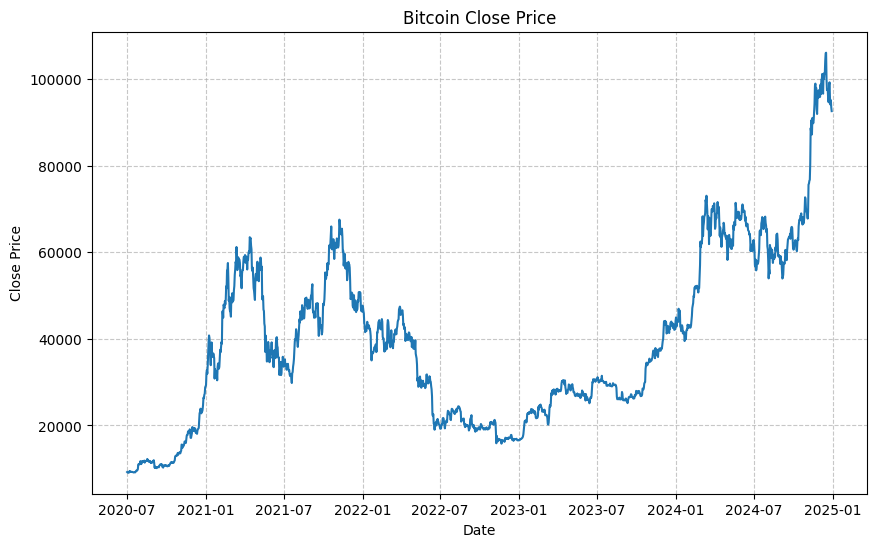

In [18]:
plot_time_series(btc_data, 'Bitcoin Close Price')

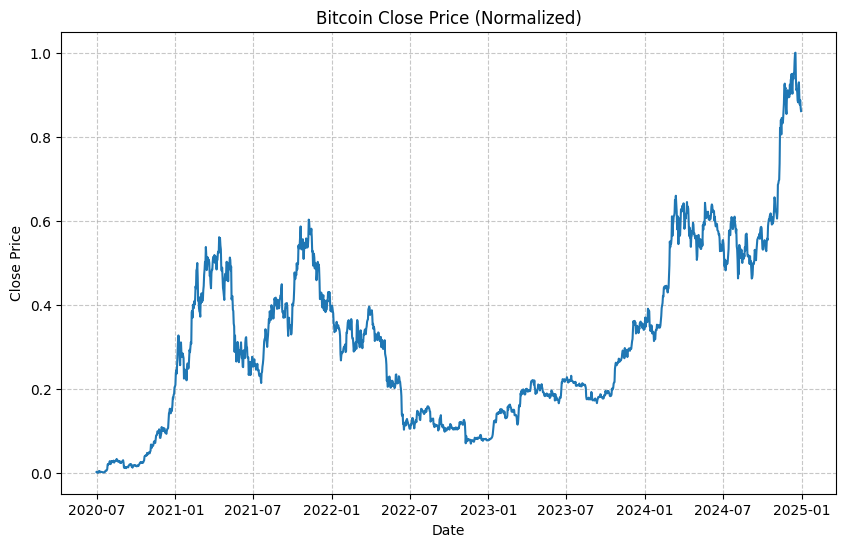

In [19]:
plot_time_series(btc_data_normalized, 'Bitcoin Close Price (Normalized)')

#### ETHEREUM

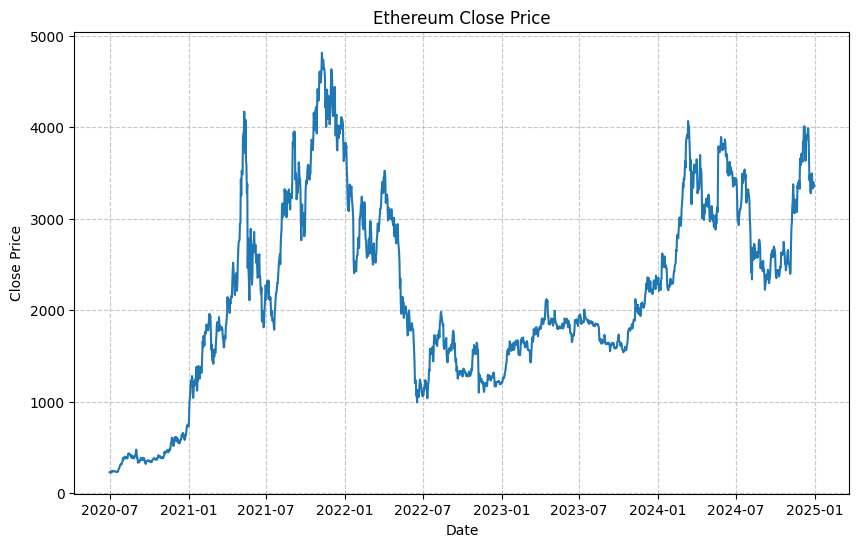

In [20]:
plot_time_series(eth_data, 'Ethereum Close Price')

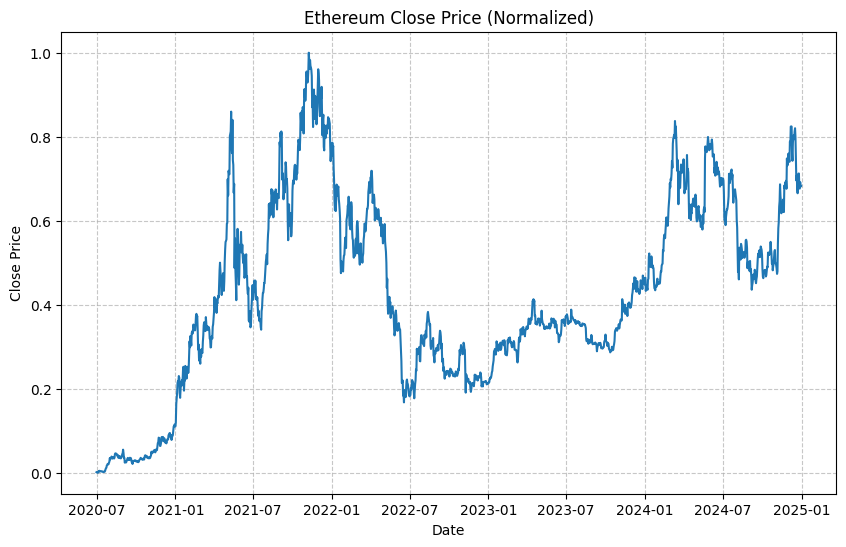

In [21]:
plot_time_series(eth_data_normalized, 'Ethereum Close Price (Normalized)')

#### EDA SPLIT

In [22]:
def plot_crypto_splits(crypto_data, crypto_name):

    # Mapping nama crypto
    crypto_names = {
        "BTC": "Bitcoin",
        "ETH": "Ethereum"
    }
    
    # Menggunakan nama lengkap jika ada dalam kamus, jika tidak pakai uppercase input
    full_name = crypto_names.get(crypto_name.upper(), crypto_name.upper())

    # Definisikan periode split
    splits = {
        "Split 1": ('2020-07-01', '2021-06-30'),
        "Split 2": ('2021-07-01', '2022-06-30'),
        "Split 3": ('2022-07-01', '2023-06-30'),
        "Split 4": ('2023-07-01', '2024-06-30'),
        "Test": ('2024-07-01', '2024-12-31')
    }

    plt.figure(figsize=(14, 8))

    for split_name, (start_date, end_date) in splits.items():
        split_data = crypto_data.loc[start_date:end_date, 'Close']
        plt.plot(split_data.index, split_data.values, label=split_name)

    # Konfigurasi plot
    plt.title(f'{full_name} Close Price by Splits', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

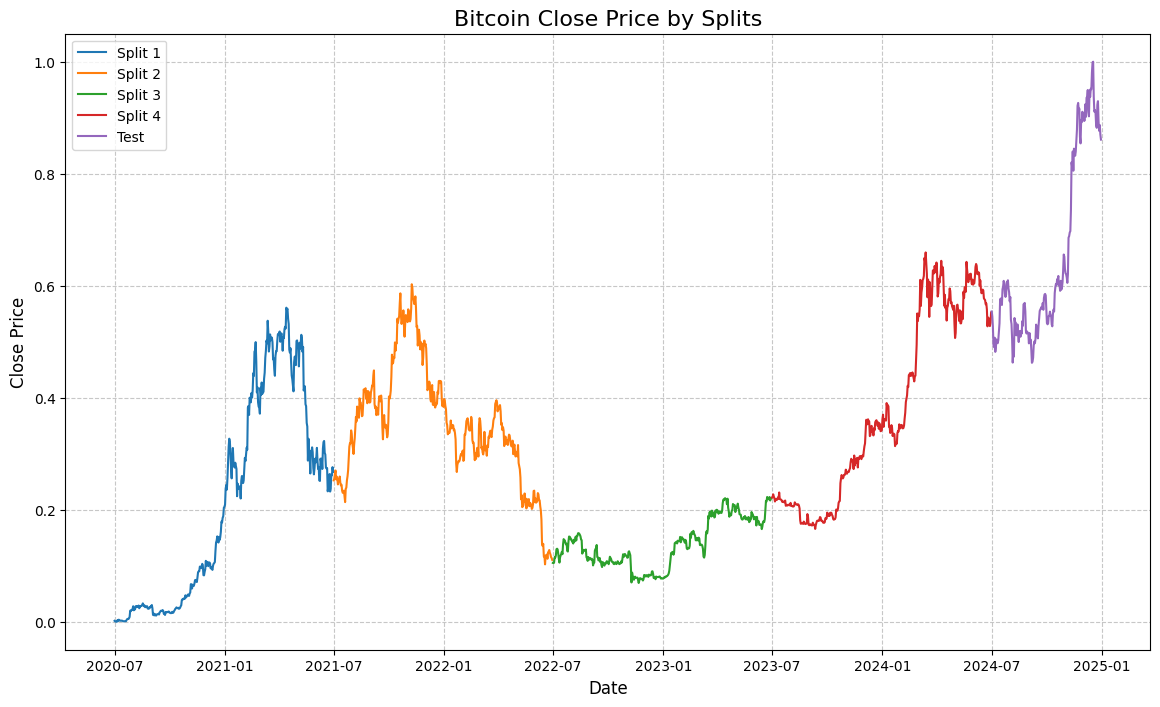

In [23]:
# Plot data BTC
plot_crypto_splits(btc_data_normalized, 'BTC')

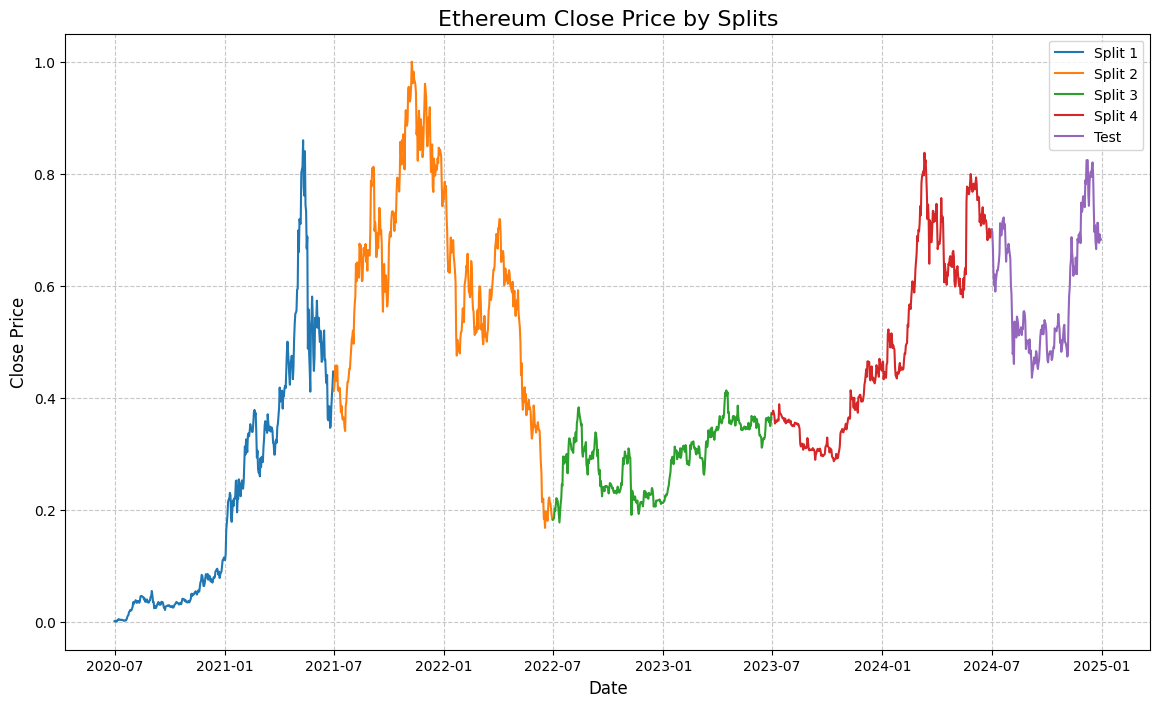

In [24]:
# Plot data ETH
plot_crypto_splits(eth_data_normalized, 'ETH')

## **ROLLING WINDOW VALIDATION**

#### DEFINE FUNGSI

In [25]:
def rolling_window_split(data, crypto_name, window_sizes=[7, 14]):
    
    dataframes = {}

    start_date = datetime(2020, 6, 1)  # Mulai dari Juni 2020
    end_date = datetime(2024, 6, 30)  # Data validasi terakhir hingga Juni 2024
    test_start = datetime(2024, 7, 1)  # Data testing mulai Juli 2024
    test_end = datetime(2024, 12, 31)  # Data testing hingga Desember 2024

    split_idx = 1

    while start_date + timedelta(days=365) <= end_date:
        train_start = start_date
        train_end = start_date + timedelta(days=303)  # 10 bulan dari train_start
        val_start = train_end + timedelta(days=1)
        val_end = val_start + timedelta(days=60)  # 2 bulan dari val_start

        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        val_data = data[(data.index >= val_start) & (data.index <= val_end)]

        for ws in window_sizes:
            # Buat fitur untuk setiap window size
            train_X, train_y = create_features(train_data, ws)
            val_X, val_y = create_features(val_data, ws)

            # Simpan hasil split ke dictionary dengan nama unik
            dataframes[f'{crypto_name}_split{split_idx}_ws{ws}_train_X'] = train_X
            dataframes[f'{crypto_name}_split{split_idx}_ws{ws}_train_y'] = train_y
            dataframes[f'{crypto_name}_split{split_idx}_ws{ws}_val_X'] = val_X
            dataframes[f'{crypto_name}_split{split_idx}_ws{ws}_val_y'] = val_y

        # Pindahkan jendela ke 1 tahun berikutnya
        start_date += timedelta(days=365)
        split_idx += 1

    # Untuk data testing (Juli 2024 - Desember 2024)
    test_data = data[(data.index >= test_start) & (data.index <= test_end)]

    for ws in window_sizes:
        test_X, test_y = create_features(test_data, ws)
        dataframes[f'{crypto_name}_ws{ws}_test_X'] = test_X
        dataframes[f'{crypto_name}_ws{ws}_test_y'] = test_y

    return dataframes

def create_features(data, time_step, target_col=None):

    if target_col is None:
        target_col = data.columns[-1]  # Default ke kolom terakhir jika target tidak ditentukan

    X, y = [], []
    values = data.values

    for i in range(len(values) - time_step):
        # Ambil window time_step sebagai input
        X.append(values[i:i + time_step])  # Tanpa reshape, gunakan format tabular
        # Output adalah target pada time_step berikutnya
        y.append(values[i + time_step, data.columns.get_loc(target_col)])

    # Konversi ke DataFrame
    X = pd.DataFrame(
        np.array(X).reshape(len(X), -1),
        columns=[f'{col}_t-{t}' for t in range(time_step, 0, -1) for col in data.columns]
    )
    y = pd.Series(y, name=target_col)

    return X, y

#### PENERAPAN

In [26]:
# Contoh penggunaan fungsi:
dataframes_btc = rolling_window_split(btc_data_normalized, 'btc', window_sizes=[7, 14])
dataframes_eth = rolling_window_split(eth_data_normalized, 'eth', window_sizes=[7, 14])

# Cek hasil
print("BTC Data Splits:", dataframes_btc.keys())
print("ETH Data Splits:", dataframes_eth.keys())

BTC Data Splits: dict_keys(['btc_split1_ws7_train_X', 'btc_split1_ws7_train_y', 'btc_split1_ws7_val_X', 'btc_split1_ws7_val_y', 'btc_split1_ws14_train_X', 'btc_split1_ws14_train_y', 'btc_split1_ws14_val_X', 'btc_split1_ws14_val_y', 'btc_split2_ws7_train_X', 'btc_split2_ws7_train_y', 'btc_split2_ws7_val_X', 'btc_split2_ws7_val_y', 'btc_split2_ws14_train_X', 'btc_split2_ws14_train_y', 'btc_split2_ws14_val_X', 'btc_split2_ws14_val_y', 'btc_split3_ws7_train_X', 'btc_split3_ws7_train_y', 'btc_split3_ws7_val_X', 'btc_split3_ws7_val_y', 'btc_split3_ws14_train_X', 'btc_split3_ws14_train_y', 'btc_split3_ws14_val_X', 'btc_split3_ws14_val_y', 'btc_split4_ws7_train_X', 'btc_split4_ws7_train_y', 'btc_split4_ws7_val_X', 'btc_split4_ws7_val_y', 'btc_split4_ws14_train_X', 'btc_split4_ws14_train_y', 'btc_split4_ws14_val_X', 'btc_split4_ws14_val_y', 'btc_ws7_test_X', 'btc_ws7_test_y', 'btc_ws14_test_X', 'btc_ws14_test_y'])
ETH Data Splits: dict_keys(['eth_split1_ws7_train_X', 'eth_split1_ws7_train_y', '

## **MODEL CNN-BilSTM**

In [38]:
# Fungsi untuk mencatat waktu
def log_time_progress(message):
    print(message)
    return time.time()

In [27]:
# Fungsi untuk menghitung MAPE
def evaluate_mape(y_actual, y_predicted, scaler=None):
    y_actual = np.where(y_actual == 0, np.finfo(float).eps, y_actual)
    mape = np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100
    return mape

# Fungsi untuk menghitung RMSE
def evaluate_rmse(y_actual, y_predicted, scaler=None):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

def evaluate_direction_accuracy(y_actual, predictions):
    y_actual_direction = np.sign(np.diff(y_actual.flatten()))
    pred_direction = np.sign(np.diff(predictions.flatten()))
    direction_accuracy = accuracy_score(y_actual_direction, pred_direction) * 100
    return direction_accuracy

def evaluate_direction_accuracy(y_actual, predictions):
    # Hitung arah pergerakan harga (hanya Up (1) dan Down (-1))
    y_actual_direction = np.sign(np.diff(y_actual.flatten()))
    pred_direction = np.sign(np.diff(predictions.flatten()))

    # Filter hanya Up (1) dan Down (-1), buang No Change (0)
    mask = (y_actual_direction != 0) & (pred_direction != 0)
    y_actual_filtered = y_actual_direction[mask]
    pred_filtered = pred_direction[mask]

    # Hitung akurasi arah
    direction_accuracy = accuracy_score(y_actual_filtered, pred_filtered) * 100

    # Hitung Confusion Matrix (hanya untuk Up dan Down)
    cm = confusion_matrix(y_actual_filtered, pred_filtered, labels=[-1, 1])
    print("Confusion Matrix")
    print(cm)

    return direction_accuracy

In [28]:
# Fungsi untuk membangun CNN-BiLSTM model
def build_cnn_bilstm_model(input_shape, filters, kernel_size, pool_size, learning_rate, dropout_rate, bilstm_units1, bilstm_units2, dense_units):
    model = Sequential()
    # CNN Layer
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))

    # BiLSTM Layers
    model.add(Bidirectional(LSTM(bilstm_units1, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(bilstm_units2)))

    # Dense Layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [30]:
save_dir = "/kaggle/working/cnn-bilstm"
os.makedirs(save_dir, exist_ok=True)

In [31]:
# Fungsi untuk menambahkan ModelCheckpoint
def get_model_checkpoint(asset, window_size, split_idx):
    # Tentukan lokasi penyimpanan model terbaik
    model_filename = (f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras")
    model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', save_best_only=True)
    return model_checkpoint

In [32]:
def train_and_validate_split(
    asset, window_size, train_data, val_data, best_params, split_idx, scaler, save_dir
):

    train_X, train_y = train_data
    val_X, val_y = val_data

    # Bangun model dengan hyperparameters terbaik
    model = build_cnn_bilstm_model(
        input_shape=(train_X.shape[1], 1),
        filters=best_params['filters'],
        kernel_size=best_params['kernel_size'],
        pool_size=best_params['pool_size'],
        learning_rate=best_params['learning_rate'],
        dropout_rate=best_params['dropout_rate'],
        bilstm_units1=best_params['bilstm_units1'],
        bilstm_units2=best_params['bilstm_units2'],
        dense_units=best_params['dense_units']
    )

    # Checkpoint
    model_checkpoint = get_model_checkpoint(asset, window_size, split_idx)
    history = model.fit(
        train_X, train_y,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[model_checkpoint]
    )

    # Plot Loss (MSE) Training & Validation
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title(f'Training & Validation Loss - {asset.upper()} WS{window_size} Split{split_idx}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    # Hitung rata-rata loss selama pelatihan
    avg_train_loss = np.mean(history.history['loss'])
    avg_val_loss = np.mean(history.history['val_loss'])

    print(f"[{asset.upper()} - WS{window_size} - Split {split_idx}] Best Model saved")
    print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}")

    model.save(f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras")
    return model

In [33]:
def perform_rwcv(asset, window_size, best_params, dataframes, scaler, save_dir):

    window_size_str = f'ws{window_size}'

    for split_idx in range(1, 5):
        print(f"\n=== Training {asset.upper()} (WS{window_size}) on Split {split_idx} ===")

        # Ambil data train & val
        train_X = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_train_X')
        train_y = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_train_y')
        val_X = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_val_X')
        val_y = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_val_y')

        # Latih & Validasi
        train_and_validate_split(
            asset, window_size,
            (train_X, train_y), (val_X, val_y),
            best_params, split_idx, scaler,
            save_dir
        )

In [34]:
def evaluate_test_model(asset, window_size, split_idx, dataframes, scaler, save_dir):

    window_size_str = f'ws{window_size}'

    # Path model terbaik (sesuai naming checkpoint)
    model_filename = f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras"

    print(f"\nLoading best model: {model_filename}")
    model = load_model(model_filename)

    # Ambil data test
    test_X = dataframes.get(f'{asset.lower()}_{window_size_str}_test_X')
    test_y = dataframes.get(f'{asset.lower()}_{window_size_str}_test_y')

    # Prediksi
    predictions = model.predict(test_X)

    # Inverse transform
    test_y_original = scaler.inverse_transform(test_y.values.reshape(-1, 1)).flatten()
    predictions_original = scaler.inverse_transform(predictions).flatten()

    # Hitung metrik
    mape = evaluate_mape(test_y_original, predictions_original)
    da = evaluate_direction_accuracy(test_y_original, predictions_original)
    rmse = evaluate_rmse(test_y_original, predictions_original)

    print(f"[Test Evaluation] {asset.upper()} WS{window_size} Split {split_idx}")
    print(f"MAPE: {mape:.4f}%, DA: {da:.4f}%, RMSE: {rmse:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_y_original, label='Actual', color='blue')
    plt.plot(predictions_original, label='Predicted', color='red')
    plt.title(f"{asset.upper()} - WS{window_size} - Split Test")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

#### BTC

In [35]:
# Fungsi untuk mendefinisikan Objective untuk optimasi Optuna
def objective_btc_split(trial, split_idx, asset, window_size):
    filters = trial.suggest_categorical('filters', [32])
    kernel_size = trial.suggest_categorical('kernel_size', [3])
    pool_size = trial.suggest_categorical('pool_size', [1])
    bilstm_units1 = trial.suggest_categorical('bilstm_units1', [32, 64, 128])
    bilstm_units2 = trial.suggest_categorical('bilstm_units2', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [100, 200, 300])

    # Load dataset sesuai split
    train_X = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_train_X']
    train_y = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_train_y']
    val_X = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_val_X']
    val_y = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_val_y']

    # Build model
    model = build_cnn_bilstm_model(
        input_shape=(train_X.shape[1], 1),
        filters=filters,
        kernel_size=kernel_size,
        pool_size=pool_size,
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        bilstm_units1=bilstm_units1,
        bilstm_units2=bilstm_units2,
        dense_units=dense_units
    )

    # Training model
    history = model.fit(
        train_X, train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluation using validation data
    val_predictions = model.predict(val_X)
    val_mse = mean_squared_error(val_y, val_predictions)
    return val_mse

In [39]:
def optimize_split_2(asset, window_size):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    print(f"Optimizing {asset} {window_size} - Split 2")
    optimization_start_time = log_time_progress(f"Starting Optuna optimization for {asset} {window_size} - Split 2")
    study.optimize(lambda trial: objective_btc_split(trial, 2, asset, window_size), n_trials=50)
    best_params = study.best_params
    print(f"Best params for {asset} {window_size} - Split 2:", best_params)
    return best_params

In [40]:
# Optimasi untuk split 2
best_params_btc_7 = optimize_split_2('BTC', 'ws7')

[I 2025-03-05 13:39:06,947] A new study created in memory with name: no-name-64065f48-a491-47fa-ac5f-8852473277c7


Optimizing BTC ws7 - Split 2
Starting Optuna optimization for BTC ws7 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step


[I 2025-03-05 13:39:24,283] Trial 0 finished with value: 0.005243947430287336 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.005243947430287336.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


[I 2025-03-05 13:39:32,654] Trial 1 finished with value: 0.0003074262061108075 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.0003074262061108075.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:39:37,741] Trial 2 finished with value: 0.004713027370111478 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.0003074262061108075.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-03-05 13:39:43,149] Trial 3 finished with value: 8.824506661471421 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 1 with value: 0.0003074262061108075.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


[I 2025-03-05 13:39:48,639] Trial 4 finished with value: 0.01205193664842098 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.0003074262061108075.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:39:53,748] Trial 5 finished with value: 2.269785521087159 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 1 with value: 0.0003074262061108075.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2025-03-05 13:40:00,293] Trial 6 finished with value: 0.0002988620679405841 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.0002988620679405841.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-03-05 13:40:05,671] Trial 7 finished with value: 0.021687621988479268 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 6 with value: 0.0002988620679405841.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-03-05 13:40:14,223] Trial 8 finished with value: 0.0002447552517661274 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 13:40:19,110] Trial 9 finished with value: 0.005202310261719702 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 13:40:24,681] Trial 10 finished with value: 0.009960949439078458 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 13:40:30,070] Trial 11 finished with value: 0.0364583667207712 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 13:40:36,057] Trial 12 finished with value: 0.03097726791238447 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:40:41,429] Trial 13 finished with value: 0.03434889555224704 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2025-03-05 13:40:46,884] Trial 14 finished with value: 0.00875469051324281 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 13:40:52,382] Trial 15 finished with value: 0.04418935763668283 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2025-03-05 13:40:59,557] Trial 16 finished with value: 0.004598436973519816 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-03-05 13:41:04,960] Trial 17 finished with value: 0.01840462938115615 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-03-05 13:41:10,342] Trial 18 finished with value: 0.0026301552928037477 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-03-05 13:41:16,455] Trial 19 finished with value: 0.0010854641855082457 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 13:41:21,836] Trial 20 finished with value: 0.02054469618085928 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-03-05 13:41:29,202] Trial 21 finished with value: 0.01622904803912872 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 13:41:35,334] Trial 22 finished with value: 0.033919241688766415 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 13:41:41,482] Trial 23 finished with value: 0.0025097824932342064 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 13:41:47,561] Trial 24 finished with value: 0.022581255250415017 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 13:41:53,709] Trial 25 finished with value: 0.010108978651334498 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 13:41:59,242] Trial 26 finished with value: 0.0396556354310607 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:42:05,995] Trial 27 finished with value: 0.026520973907949247 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2025-03-05 13:42:11,051] Trial 28 finished with value: 1.1272717714397391 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 13:42:17,087] Trial 29 finished with value: 0.0007067242985198868 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 13:42:23,163] Trial 30 finished with value: 0.06145655734271345 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 13:42:29,234] Trial 31 finished with value: 0.0010417572728974507 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 13:42:35,454] Trial 32 finished with value: 0.0009739557228738237 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 13:42:41,637] Trial 33 finished with value: 0.0026001575972148722 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


[I 2025-03-05 13:42:49,133] Trial 34 finished with value: 0.0011651145467873572 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 13:42:54,192] Trial 35 finished with value: 0.015030301099340072 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:43:00,350] Trial 36 finished with value: 0.002046005216574545 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 13:43:05,381] Trial 37 finished with value: 3.1959402785153 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step


[I 2025-03-05 13:43:10,726] Trial 38 finished with value: 0.02387320431783328 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-03-05 13:43:16,006] Trial 39 finished with value: 93.41543241388665 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


[I 2025-03-05 13:43:20,955] Trial 40 finished with value: 0.021160240494510638 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 13:43:27,042] Trial 41 finished with value: 0.0009461416237762392 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step


[I 2025-03-05 13:43:33,146] Trial 42 finished with value: 0.0008842864441881875 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:43:41,047] Trial 43 finished with value: 0.0018385010510348244 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


[I 2025-03-05 13:43:47,214] Trial 44 finished with value: 0.0008153482528149522 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2025-03-05 13:43:52,687] Trial 45 finished with value: 0.031236684522895627 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 13:43:58,782] Trial 46 finished with value: 0.0011889369901045782 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 13:44:04,124] Trial 47 finished with value: 0.047111638485046646 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step


[I 2025-03-05 13:44:09,544] Trial 48 finished with value: 0.0012454860645270346 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.0002447552517661274.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 13:44:15,705] Trial 49 finished with value: 0.0012447405176711944 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.0002447552517661274.


Best params for BTC ws7 - Split 2: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}


In [41]:
#Best params based on box-plot
best_params_btc_7 = {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 
                     'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 
                     'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}

In [42]:
# Optimasi untuk split 2
best_params_btc_14 = optimize_split_2('BTC', 'ws14')

[I 2025-03-05 13:46:23,964] A new study created in memory with name: no-name-b24b5536-0bd4-4d65-a592-1ad5cf5eee4b


Optimizing BTC ws14 - Split 2
Starting Optuna optimization for BTC ws14 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step


[I 2025-03-05 13:46:30,479] Trial 0 finished with value: 0.012950379054852152 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.012950379054852152.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-03-05 13:46:36,886] Trial 1 finished with value: 0.0071603203779949725 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.0071603203779949725.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-03-05 13:46:44,176] Trial 2 finished with value: 0.025909090804307956 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.0071603203779949725.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


[I 2025-03-05 13:46:49,877] Trial 3 finished with value: 0.3581034768446179 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 1 with value: 0.0071603203779949725.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


[I 2025-03-05 13:46:55,076] Trial 4 finished with value: 0.01119395553111955 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.0071603203779949725.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:47:00,272] Trial 5 finished with value: 8.621472256095787 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 1 with value: 0.0071603203779949725.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-03-05 13:47:05,903] Trial 6 finished with value: 0.004169462631479719 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.004169462631479719.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 13:47:11,441] Trial 7 finished with value: 0.1451925537487264 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 6 with value: 0.004169462631479719.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2025-03-05 13:47:17,064] Trial 8 finished with value: 0.01102155749320548 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 6 with value: 0.004169462631479719.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 13:47:22,146] Trial 9 finished with value: 0.005232482254239703 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 6 with value: 0.004169462631479719.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step


[I 2025-03-05 13:47:27,680] Trial 10 finished with value: 0.0050294553943841126 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.004169462631479719.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 13:47:33,299] Trial 11 finished with value: 0.03292242027390356 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.004169462631479719.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-03-05 13:47:38,900] Trial 12 finished with value: 0.0056302665488009536 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.004169462631479719.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step


[I 2025-03-05 13:47:47,182] Trial 13 finished with value: 0.023334336563787028 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.004169462631479719.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:47:52,912] Trial 14 finished with value: 0.030979370321601554 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.004169462631479719.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


[I 2025-03-05 13:47:58,480] Trial 15 finished with value: 0.0019869329503233875 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 15 with value: 0.0019869329503233875.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 13:48:04,841] Trial 16 finished with value: 0.0008706366247557196 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 16 with value: 0.0008706366247557196.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 13:48:11,031] Trial 17 finished with value: 0.0014133901985250719 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.0008706366247557196.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step


[I 2025-03-05 13:48:17,255] Trial 18 finished with value: 0.002098564305433173 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.0008706366247557196.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:48:23,577] Trial 19 finished with value: 0.0073944162655190365 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.0008706366247557196.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-03-05 13:48:29,761] Trial 20 finished with value: 0.0013651452079564916 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.0008706366247557196.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step


[I 2025-03-05 13:48:36,054] Trial 21 finished with value: 0.0012465379088617142 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.0008706366247557196.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step


[I 2025-03-05 13:48:42,418] Trial 22 finished with value: 0.0011765776235334203 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.0008706366247557196.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


[I 2025-03-05 13:48:48,697] Trial 23 finished with value: 0.0009615179037206464 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.0008706366247557196.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2025-03-05 13:48:55,071] Trial 24 finished with value: 0.0008048389927392178 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 24 with value: 0.0008048389927392178.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step


[I 2025-03-05 13:49:01,462] Trial 25 finished with value: 0.0007054119374196599 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-03-05 13:49:10,482] Trial 26 finished with value: 0.000808581088667478 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


[I 2025-03-05 13:49:16,919] Trial 27 finished with value: 0.0007760755719270821 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


[I 2025-03-05 13:49:23,426] Trial 28 finished with value: 0.019306127542750677 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 13:49:29,771] Trial 29 finished with value: 0.012874205575597063 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 13:49:35,969] Trial 30 finished with value: 0.013596137184217533 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 13:49:42,196] Trial 31 finished with value: 0.0008469225995837809 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 13:49:48,438] Trial 32 finished with value: 0.0013289567510211082 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 13:49:54,786] Trial 33 finished with value: 0.00087908483444035 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 13:50:01,093] Trial 34 finished with value: 0.008338303737979853 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 13:50:07,339] Trial 35 finished with value: 0.0007935033235602359 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 13:50:12,522] Trial 36 finished with value: 0.014859118844659652 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 13:50:18,908] Trial 37 finished with value: 0.39081354766472237 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 200}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-03-05 13:50:25,357] Trial 38 finished with value: 0.0015683324486218514 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 13:50:30,407] Trial 39 finished with value: 0.005338653965698538 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2025-03-05 13:50:36,793] Trial 40 finished with value: 0.3258410720144369 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step


[I 2025-03-05 13:50:46,353] Trial 41 finished with value: 0.0007617584542066298 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2025-03-05 13:50:52,883] Trial 42 finished with value: 0.0010641219875658907 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2025-03-05 13:50:59,312] Trial 43 finished with value: 0.0008867896204213374 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 13:51:05,631] Trial 44 finished with value: 0.000788837481115007 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step


[I 2025-03-05 13:51:10,765] Trial 45 finished with value: 0.002276983217564616 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


[I 2025-03-05 13:51:17,020] Trial 46 finished with value: 0.000907132171343172 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


[I 2025-03-05 13:51:23,407] Trial 47 finished with value: 0.0027542582964055896 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 13:51:29,884] Trial 48 finished with value: 0.011010926545638575 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:51:34,928] Trial 49 finished with value: 0.0020319955960382717 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 25 with value: 0.0007054119374196599.


Best params for BTC ws14 - Split 2: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


In [43]:
best_params_btc_14 = {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 
                      'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 
                      'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


=== Training BTC (WS7) on Split 1 ===


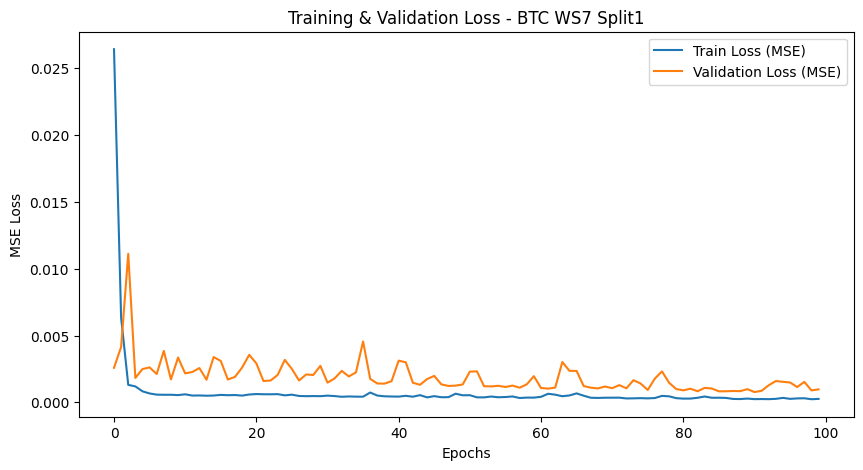

[BTC - WS7 - Split 1] Best Model saved
Avg Train Loss: 0.0008, Avg Validation Loss: 0.0019

=== Training BTC (WS7) on Split 2 ===


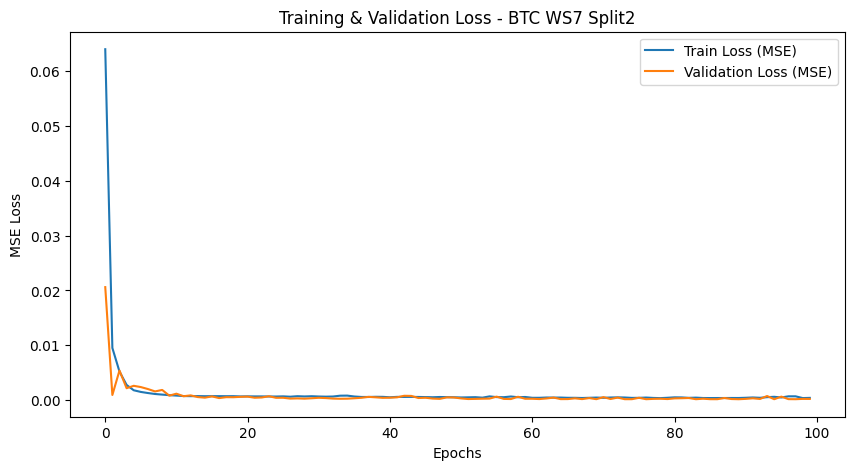

[BTC - WS7 - Split 2] Best Model saved
Avg Train Loss: 0.0014, Avg Validation Loss: 0.0007

=== Training BTC (WS7) on Split 3 ===


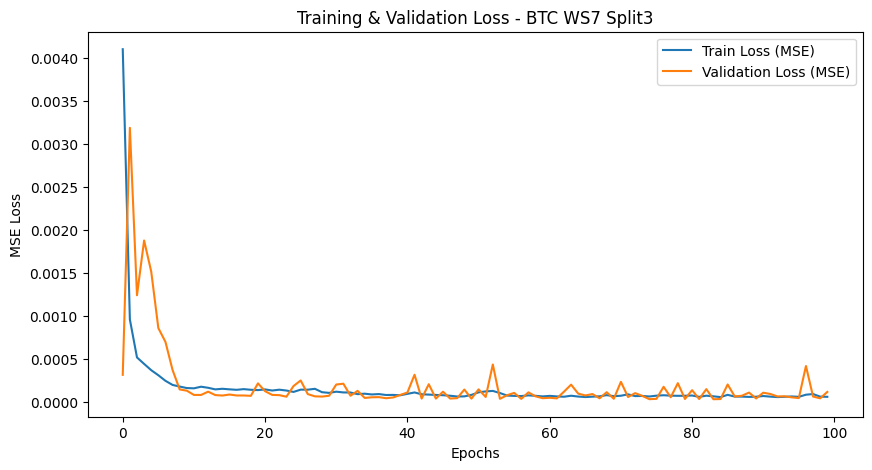

[BTC - WS7 - Split 3] Best Model saved
Avg Train Loss: 0.0002, Avg Validation Loss: 0.0002

=== Training BTC (WS7) on Split 4 ===


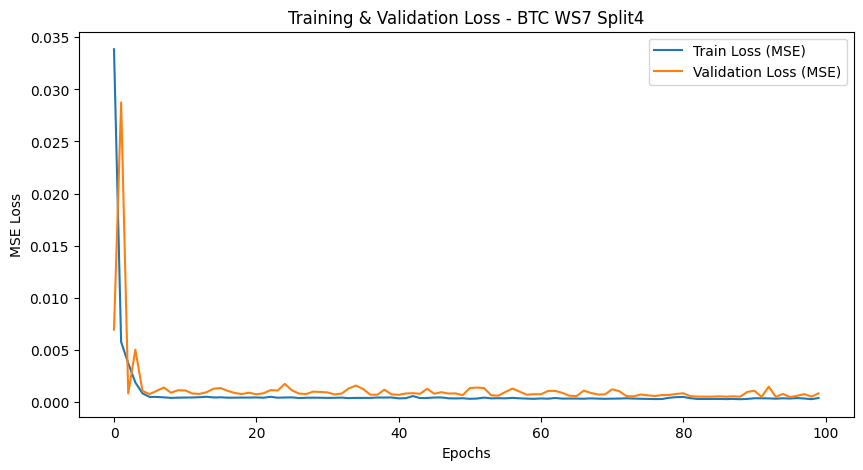

[BTC - WS7 - Split 4] Best Model saved
Avg Train Loss: 0.0008, Avg Validation Loss: 0.0012


In [44]:
perform_rwcv("btc", 7, best_params_btc_7, dataframes_btc, btc_scaler, save_dir="/kaggle/working/cnn-bilstm")

### ETH

In [45]:
# Fungsi untuk mendefinisikan Objective untuk optimasi Optuna
def objective_eth_split(trial, split_idx, asset, window_size):
    filters = trial.suggest_categorical('filters', [32])
    kernel_size = trial.suggest_categorical('kernel_size', [3])
    pool_size = trial.suggest_categorical('pool_size', [1])
    bilstm_units1 = trial.suggest_categorical('bilstm_units1', [32, 64, 128])
    bilstm_units2 = trial.suggest_categorical('bilstm_units2', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [100, 200, 300])

    # Load dataset sesuai split
    train_X = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_train_X']
    train_y = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_train_y']
    val_X = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_val_X']
    val_y = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_val_y']

    # Build model
    model = build_cnn_bilstm_model(
        input_shape=(train_X.shape[1], 1),
        filters=filters,
        kernel_size=kernel_size,
        pool_size=pool_size,
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        bilstm_units1=bilstm_units1,
        bilstm_units2=bilstm_units2,
        dense_units=dense_units
    )

    # Training model
    history = model.fit(
        train_X, train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluation using validation data
    val_predictions = model.predict(val_X)
    val_mse = mean_squared_error(val_y, val_predictions)
    return val_mse

In [46]:
def optimize_split_2(asset, window_size):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    print(f"Optimizing {asset} {window_size} - Split 2")
    optimization_start_time = log_time_progress(f"Starting Optuna optimization for {asset} {window_size} - Split 2")
    study.optimize(lambda trial: objective_eth_split(trial, 2, asset, window_size), n_trials=50)
    best_params = study.best_params
    print(f"Best params for {asset} {window_size} - Split 2:", best_params)
    return best_params

In [47]:
# Optimasi untuk split 2
best_params_eth_7 = optimize_split_2('ETH', 'ws7')

[I 2025-03-05 13:56:42,730] A new study created in memory with name: no-name-8eef8e21-1731-4ca4-a736-923c8a859c01


Optimizing ETH ws7 - Split 2
Starting Optuna optimization for ETH ws7 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 13:56:48,909] Trial 0 finished with value: 0.04824703920500303 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.04824703920500303.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-03-05 13:56:55,129] Trial 1 finished with value: 0.011430974837334464 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.011430974837334464.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2025-03-05 13:57:00,158] Trial 2 finished with value: 0.01519750104177135 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.011430974837334464.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-03-05 13:57:05,587] Trial 3 finished with value: 30.172830970950493 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 1 with value: 0.011430974837334464.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-03-05 13:57:10,586] Trial 4 finished with value: 0.03878167700048006 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.011430974837334464.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step


[I 2025-03-05 13:57:19,454] Trial 5 finished with value: 1.4207407056089763 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 1 with value: 0.011430974837334464.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 13:57:25,018] Trial 6 finished with value: 0.005865765336628763 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.005865765336628763.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 13:57:30,446] Trial 7 finished with value: 0.42288960473480103 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 6 with value: 0.005865765336628763.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-03-05 13:57:35,938] Trial 8 finished with value: 0.10838880884633044 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 6 with value: 0.005865765336628763.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step


[I 2025-03-05 13:57:40,964] Trial 9 finished with value: 0.005676931633548977 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.005676931633548977.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2025-03-05 13:57:46,061] Trial 10 finished with value: 0.12346692689820703 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.005676931633548977.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 13:57:51,485] Trial 11 finished with value: 0.003019497057017597 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-03-05 13:57:56,824] Trial 12 finished with value: 0.030115301885505805 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-03-05 13:58:01,820] Trial 13 finished with value: 0.01893587415100242 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 13:58:07,923] Trial 14 finished with value: 0.004584341687512068 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 13:58:13,996] Trial 15 finished with value: 0.011016506102894067 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 13:58:20,136] Trial 16 finished with value: 0.0669528359070874 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 13:58:26,267] Trial 17 finished with value: 0.0059427169097590726 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 13:58:31,717] Trial 18 finished with value: 0.13690608650929895 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 13:58:37,774] Trial 19 finished with value: 0.007796812453337027 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 13:58:43,901] Trial 20 finished with value: 0.00596272533563969 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


[I 2025-03-05 13:58:48,932] Trial 21 finished with value: 0.031872461634135235 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:58:54,359] Trial 22 finished with value: 0.05346494350266721 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-03-05 13:58:59,403] Trial 23 finished with value: 0.22887754825002823 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 13:59:05,531] Trial 24 finished with value: 0.005524818684262077 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


[I 2025-03-05 13:59:15,989] Trial 25 finished with value: 0.029667700881262152 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2025-03-05 13:59:22,520] Trial 26 finished with value: 0.006960253140510063 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 13:59:28,782] Trial 27 finished with value: 0.008250865102659396 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-03-05 13:59:35,087] Trial 28 finished with value: 0.1305272074558402 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step


[I 2025-03-05 13:59:41,295] Trial 29 finished with value: 0.02001265288377048 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 13:59:46,672] Trial 30 finished with value: 0.012994867043680667 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step


[I 2025-03-05 13:59:51,770] Trial 31 finished with value: 0.003548521055503389 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 13:59:57,986] Trial 32 finished with value: 0.007181069401238329 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-03-05 14:00:04,153] Trial 33 finished with value: 0.0586952505250679 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 14:00:09,150] Trial 34 finished with value: 0.25676706781479847 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 14:00:14,563] Trial 35 finished with value: 0.005781815178365507 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-03-05 14:00:19,540] Trial 36 finished with value: 0.10757964560206341 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 14:00:25,878] Trial 37 finished with value: 0.013155095549983363 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-03-05 14:00:31,322] Trial 38 finished with value: 0.5204848264017998 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 14:00:36,282] Trial 39 finished with value: 0.11183632386763707 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 14:00:41,707] Trial 40 finished with value: 0.10252193744721459 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-03-05 14:00:46,657] Trial 41 finished with value: 0.06829223119350288 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-03-05 14:00:51,663] Trial 42 finished with value: 0.007665364810237302 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 14:00:56,833] Trial 43 finished with value: 0.027897656128115435 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 14:01:01,833] Trial 44 finished with value: 0.01102083255434354 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 14:01:06,804] Trial 45 finished with value: 0.4211160727051973 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 14:01:11,845] Trial 46 finished with value: 0.14083214706508498 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 14:01:17,183] Trial 47 finished with value: 0.10860340614026999 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


[I 2025-03-05 14:01:28,591] Trial 48 finished with value: 0.005494295289397206 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step


[I 2025-03-05 14:01:35,050] Trial 49 finished with value: 0.01279090712261619 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 11 with value: 0.003019497057017597.


Best params for ETH ws7 - Split 2: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}


In [48]:
best_params_eth_7 = {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 
                     'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 
                     'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}

In [49]:
# Optimasi untuk split 2
best_params_eth_14 = optimize_split_2('ETH', 'ws14')

[I 2025-03-05 14:03:37,613] A new study created in memory with name: no-name-6b5212ad-9a26-4117-b30c-f39e7cef4e7a


Optimizing ETH ws14 - Split 2
Starting Optuna optimization for ETH ws14 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-03-05 14:03:44,028] Trial 0 finished with value: 0.055548925064606944 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.055548925064606944.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 14:03:50,416] Trial 1 finished with value: 0.0625168298076235 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 0 with value: 0.055548925064606944.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-03-05 14:03:55,666] Trial 2 finished with value: 0.07926549833644976 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 0 with value: 0.055548925064606944.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


[I 2025-03-05 14:04:01,324] Trial 3 finished with value: 0.012434839185266661 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 3 with value: 0.012434839185266661.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 14:04:06,482] Trial 4 finished with value: 0.010166513082882814 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.010166513082882814.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 14:04:11,745] Trial 5 finished with value: 0.7656079485601729 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 4 with value: 0.010166513082882814.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 14:04:17,173] Trial 6 finished with value: 0.018365530306381266 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 4 with value: 0.010166513082882814.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 14:04:22,626] Trial 7 finished with value: 0.6457410308947583 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 4 with value: 0.010166513082882814.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 14:04:28,110] Trial 8 finished with value: 0.07733929731354754 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 4 with value: 0.010166513082882814.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 14:04:33,121] Trial 9 finished with value: 0.007384604537816187 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.007384604537816187.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 14:04:38,149] Trial 10 finished with value: 0.10971321692428024 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.007384604537816187.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 14:04:43,128] Trial 11 finished with value: 0.018207595946527003 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.007384604537816187.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2025-03-05 14:04:48,111] Trial 12 finished with value: 0.11607491090651242 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.007384604537816187.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-03-05 14:04:53,102] Trial 13 finished with value: 0.00236524304652123 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 14:04:58,076] Trial 14 finished with value: 0.10595924037446229 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 14:05:03,127] Trial 15 finished with value: 0.008991966006302404 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 14:05:09,394] Trial 16 finished with value: 0.005418056270998254 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 14:05:15,536] Trial 17 finished with value: 0.019632759203209418 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 14:05:21,756] Trial 18 finished with value: 0.0029702903190643613 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 14:05:27,912] Trial 19 finished with value: 0.009360532596326101 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 14:05:34,109] Trial 20 finished with value: 0.006966445292509122 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step


[I 2025-03-05 14:05:40,391] Trial 21 finished with value: 0.06244045303849368 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 14:05:46,552] Trial 22 finished with value: 0.010824498751628085 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-03-05 14:05:52,752] Trial 23 finished with value: 0.014704417770023284 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-03-05 14:05:58,931] Trial 24 finished with value: 0.003340380261343131 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step  


[I 2025-03-05 14:06:10,880] Trial 25 finished with value: 0.00705111791535541 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step


[I 2025-03-05 14:06:17,435] Trial 26 finished with value: 0.0038585812492608882 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2025-03-05 14:06:23,926] Trial 27 finished with value: 0.009041603051110401 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-03-05 14:06:29,593] Trial 28 finished with value: 0.004822412595345275 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 14:06:35,983] Trial 29 finished with value: 0.02971148116957769 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step


[I 2025-03-05 14:06:42,423] Trial 30 finished with value: 0.003077980502223526 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 14:06:48,796] Trial 31 finished with value: 0.0034544282393893034 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 14:06:55,093] Trial 32 finished with value: 0.0036523822380249587 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 14:07:01,326] Trial 33 finished with value: 0.0026053595357903806 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 14:07:07,653] Trial 34 finished with value: 0.0029484717847932337 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step


[I 2025-03-05 14:07:13,935] Trial 35 finished with value: 0.02924711111789415 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 14:07:19,026] Trial 36 finished with value: 0.012848515023098615 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 14:07:25,286] Trial 37 finished with value: 0.015799189809089717 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


[I 2025-03-05 14:07:30,811] Trial 38 finished with value: 0.06295078097253937 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 14:07:35,921] Trial 39 finished with value: 0.09842123502481048 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 14:07:41,352] Trial 40 finished with value: 0.021878741251582064 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 14:07:47,713] Trial 41 finished with value: 0.006100734421625842 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 14:07:53,913] Trial 42 finished with value: 0.0317147487433308 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-03-05 14:08:00,109] Trial 43 finished with value: 0.03305849970649423 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 14:08:06,338] Trial 44 finished with value: 0.011171677195848021 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 14:08:11,379] Trial 45 finished with value: 0.029611925965582424 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 14:08:17,639] Trial 46 finished with value: 0.0030174723131272375 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 14:08:22,758] Trial 47 finished with value: 0.23830788632676003 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-03-05 14:08:28,903] Trial 48 finished with value: 0.0025324711364865644 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.00236524304652123.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2025-03-05 14:08:34,430] Trial 49 finished with value: 0.0029874536547805624 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 13 with value: 0.00236524304652123.


Best params for ETH ws14 - Split 2: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}


In [50]:
best_params_eth_14 = {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 
                      'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 
                      'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}


=== Training ETH (WS14) on Split 1 ===


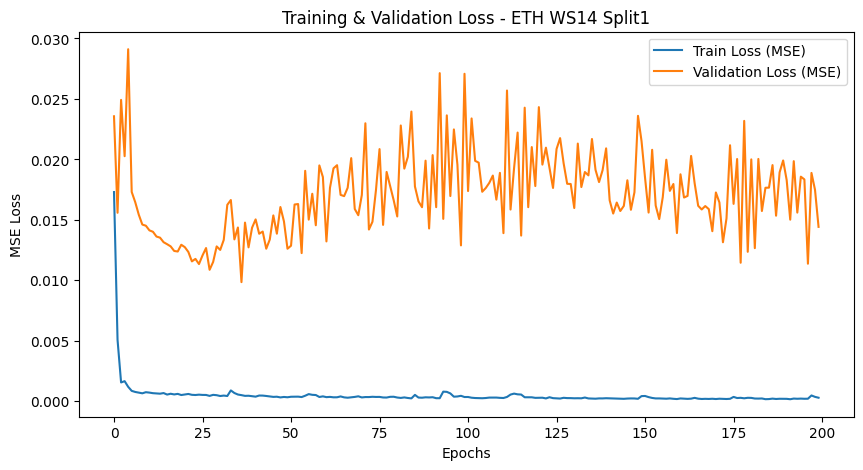

[ETH - WS14 - Split 1] Best Model saved
Avg Train Loss: 0.0005, Avg Validation Loss: 0.0171

=== Training ETH (WS14) on Split 2 ===


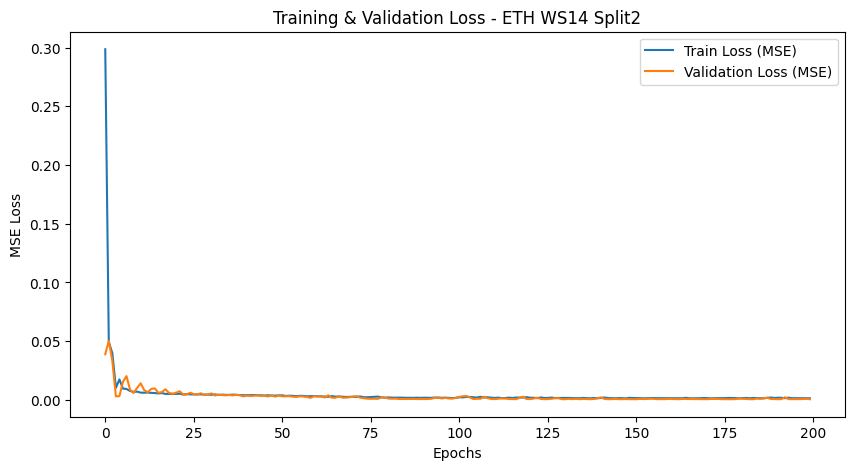

[ETH - WS14 - Split 2] Best Model saved
Avg Train Loss: 0.0046, Avg Validation Loss: 0.0028

=== Training ETH (WS14) on Split 3 ===


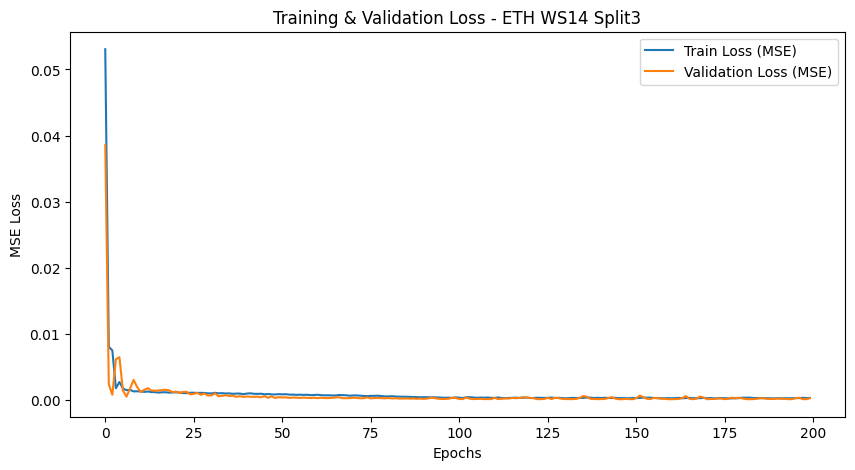

[ETH - WS14 - Split 3] Best Model saved
Avg Train Loss: 0.0009, Avg Validation Loss: 0.0006

=== Training ETH (WS14) on Split 4 ===


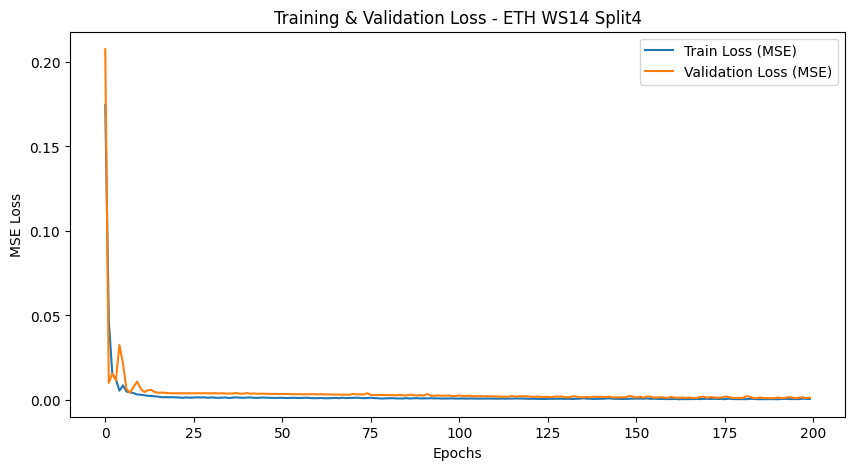

[ETH - WS14 - Split 4] Best Model saved
Avg Train Loss: 0.0023, Avg Validation Loss: 0.0041


In [51]:
perform_rwcv("eth", 14, best_params_eth_14, dataframes_eth, eth_scaler, save_dir="/kaggle/working/cnn-bilstm")


Loading best model: /kaggle/working/cnn-bilstm/best_model_btc_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Confusion Matrix
[[39 44]
 [37 55]]
[Test Evaluation] BTC WS7 Split 2
MAPE: 2.3633%, DA: 53.7143%, RMSE: 2326.8282


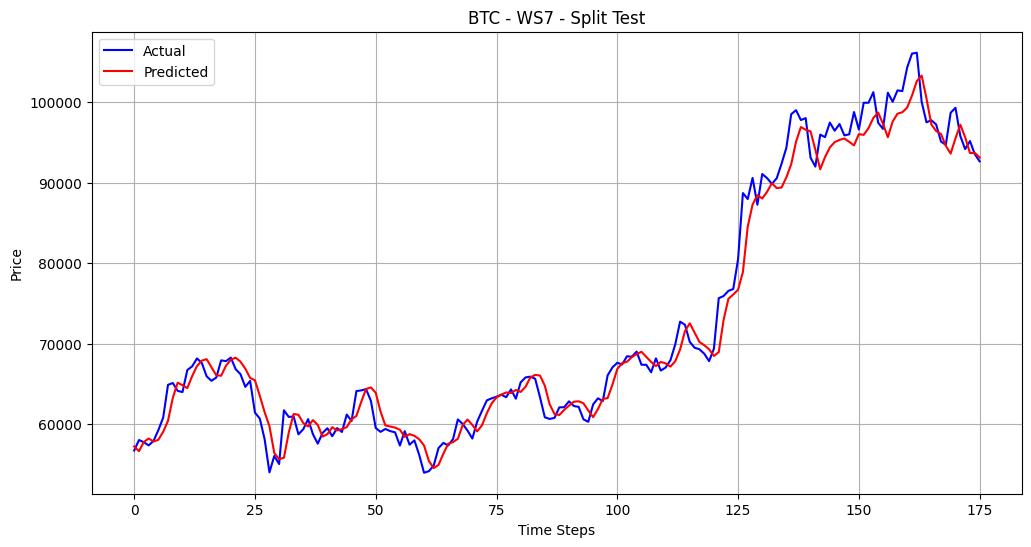

In [52]:
evaluate_test_model("btc", 7, split_idx=2, dataframes=dataframes_btc, scaler=btc_scaler, save_dir="/kaggle/working/cnn-bilstm")


Loading best model: /kaggle/working/cnn-bilstm/best_model_eth_14_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Confusion Matrix
[[41 41]
 [42 44]]
[Test Evaluation] ETH WS14 Split 2
MAPE: 2.9424%, DA: 50.5952%, RMSE: 115.3399


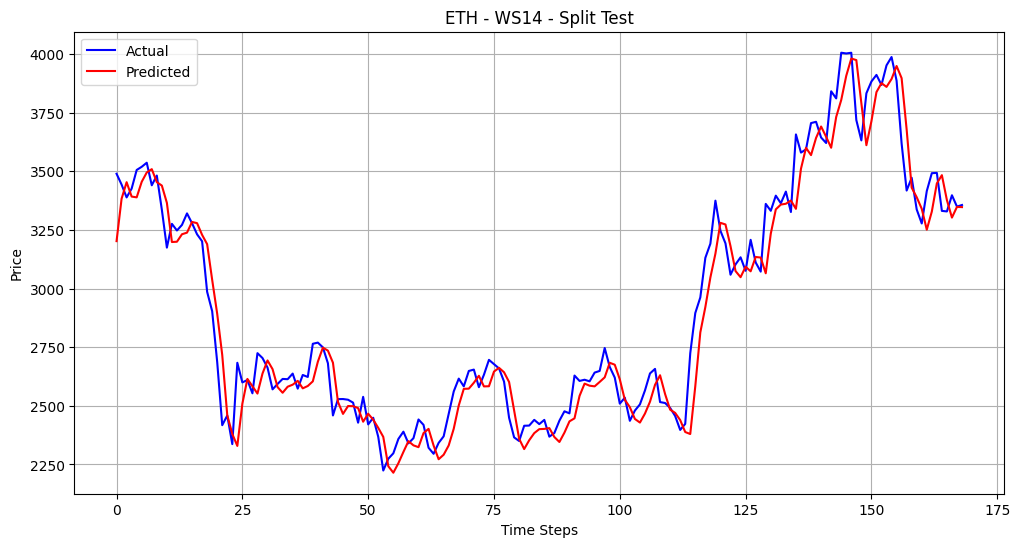

In [53]:
evaluate_test_model("eth", 14, split_idx=2, dataframes=dataframes_eth, scaler=eth_scaler, save_dir="/kaggle/working/cnn-bilstm")

## **LSTM**

In [54]:
save_dir = "/kaggle/working/lstm"
os.makedirs(save_dir, exist_ok=True)

In [55]:
# Fungsi untuk menambahkan ModelCheckpoint
def get_model_checkpoint(asset, window_size, split_idx):
    model_filename = (f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras")
    model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', save_best_only=True)
    return model_checkpoint

In [56]:
# Fungsi untuk membangun Model LSTM
def build_lstm_model(input_shape, learning_rate, dropout_rate, lstm_units1, lstm_units2, dense_units):
    model = Sequential()

    # BiLSTM Layers
    model.add(LSTM(lstm_units1, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units2))

    # Dense Layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [57]:
def train_and_validate_split(
    asset, window_size, train_data, val_data, best_params, split_idx, scaler, save_dir
):

    train_X, train_y = train_data
    val_X, val_y = val_data

    # Bangun model dengan hyperparameters terbaik
    model = build_lstm_model(
        input_shape=(train_X.shape[1], 1),
        learning_rate=best_params['learning_rate'],
        dropout_rate=best_params['dropout_rate'],
        lstm_units1=best_params['lstm_units1'],
        lstm_units2=best_params['lstm_units2'],
        dense_units=best_params['dense_units']
    )

    # Checkpoint
    model_checkpoint = get_model_checkpoint(asset, window_size, split_idx)
    history = model.fit(
        train_X, train_y,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[model_checkpoint]
    )

    # Plot Loss (MSE) Training & Validation
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title(f'Training & Validation Loss - {asset.upper()} WS{window_size} Split{split_idx}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    # Hitung rata-rata loss selama pelatihan
    avg_train_loss = np.mean(history.history['loss'])
    avg_val_loss = np.mean(history.history['val_loss'])

    print(f"[{asset.upper()} - WS{window_size} - Split {split_idx}] Best Model saved")
    print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}")

    model.save(f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras")
    return model

In [58]:
def perform_rwcv(asset, window_size, best_params, dataframes, scaler, save_dir):

    window_size_str = f'ws{window_size}'

    for split_idx in range(1, 5):
        print(f"\n=== Training {asset.upper()} (WS{window_size}) on Split {split_idx} ===")

        # Ambil data train & val
        train_X = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_train_X')
        train_y = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_train_y')
        val_X = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_val_X')
        val_y = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_val_y')

        # Latih & Validasi
        train_and_validate_split(
            asset, window_size,
            (train_X, train_y), (val_X, val_y),
            best_params, split_idx, scaler,
            save_dir
        )

In [59]:
def evaluate_test_model(asset, window_size, split_idx, dataframes, scaler, save_dir):

    window_size_str = f'ws{window_size}'

    # Path model terbaik (sesuai naming checkpoint)
    model_filename = f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras"

    print(f"\nLoading best model: {model_filename}")
    model = load_model(model_filename)

    # Ambil data test
    test_X = dataframes.get(f'{asset.lower()}_{window_size_str}_test_X')
    test_y = dataframes.get(f'{asset.lower()}_{window_size_str}_test_y')

    # Prediksi
    predictions = model.predict(test_X)

    # Inverse transform
    test_y_original = scaler.inverse_transform(test_y.values.reshape(-1, 1)).flatten()
    predictions_original = scaler.inverse_transform(predictions).flatten()

    # Hitung metrik
    mape = evaluate_mape(test_y_original, predictions_original)
    da = evaluate_direction_accuracy(test_y_original, predictions_original)
    rmse = evaluate_rmse(test_y_original, predictions_original)

    print(f"[Test Evaluation] {asset.upper()} WS{window_size} Split {split_idx}")
    print(f"MAPE: {mape:.4f}%, DA: {da:.4f}%, RMSE: {rmse:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_y_original, label='Actual', color='blue')
    plt.plot(predictions_original, label='Predicted', color='red')
    plt.title(f"{asset.upper()} - WS{window_size} - Split Test")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

#### BTC

In [60]:
# Fungsi untuk mendefinisikan Objective untuk optimasi Optuna
def objective_btc_split(trial, split_idx, asset, window_size):
    lstm_units1 = trial.suggest_categorical('lstm_units1', [32, 64, 128])
    lstm_units2 = trial.suggest_categorical('lstm_units2', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [100, 200, 300])

    # Load dataset sesuai split
    train_X = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_train_X']
    train_y = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_train_y']
    val_X = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_val_X']
    val_y = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_val_y']

    # Build model
    model = build_lstm_model(
        input_shape=(train_X.shape[1], 1),
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        lstm_units1=lstm_units1,
        lstm_units2=lstm_units2,
        dense_units=dense_units
    )

    # Training model
    history = model.fit(
        train_X, train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluation using validation data
    val_predictions = model.predict(val_X)
    val_mse = mean_squared_error(val_y, val_predictions)
    return val_mse

In [61]:
def optimize_split_2(asset, window_size):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    print(f"Optimizing {asset} {window_size} - Split 2")
    optimization_start_time = log_time_progress(f"Starting Optuna optimization for {asset} {window_size} - Split 2")
    study.optimize(lambda trial: objective_btc_split(trial, 2, asset, window_size), n_trials=50)
    best_params = study.best_params
    print(f"Best params for {asset} {window_size} - Split 2:", best_params)
    return best_params

In [62]:
# Optimasi untuk split 2
best_params_btc_7 = optimize_split_2('BTC', 'ws7')

[I 2025-03-05 14:13:34,311] A new study created in memory with name: no-name-870a7e19-7d57-47af-9694-591a1c0eede2


Optimizing BTC ws7 - Split 2
Starting Optuna optimization for BTC ws7 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:13:37,948] Trial 0 finished with value: 0.05430634823601982 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.05430634823601982.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:13:41,617] Trial 1 finished with value: 0.004139609269989879 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.004139609269989879.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2025-03-05 14:13:44,550] Trial 2 finished with value: 0.001246257102679502 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:13:47,761] Trial 3 finished with value: 0.22057522634867158 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:13:50,705] Trial 4 finished with value: 0.02503773254944817 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step  


[I 2025-03-05 14:14:00,193] Trial 5 finished with value: 0.002799624310423221 and parameters: {'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


[I 2025-03-05 14:14:03,739] Trial 6 finished with value: 0.025566774907203983 and parameters: {'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:14:07,143] Trial 7 finished with value: 0.05906851737989917 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:14:10,421] Trial 8 finished with value: 0.002459127612762488 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:14:13,467] Trial 9 finished with value: 0.02154578153496449 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:14:16,526] Trial 10 finished with value: 0.02746003391330934 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:14:19,818] Trial 11 finished with value: 0.020085278356354565 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:14:22,880] Trial 12 finished with value: 0.00430312064712788 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:14:26,139] Trial 13 finished with value: 0.016120543275066686 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:14:29,889] Trial 14 finished with value: 0.0013541715064135959 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 2 with value: 0.001246257102679502.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:14:33,678] Trial 15 finished with value: 0.001020342133029774 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 15 with value: 0.001020342133029774.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:14:37,509] Trial 16 finished with value: 0.0008511330379078005 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 16 with value: 0.0008511330379078005.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:14:41,293] Trial 17 finished with value: 0.0007866940789941474 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:14:45,060] Trial 18 finished with value: 0.0023297024773339726 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:14:48,858] Trial 19 finished with value: 0.006305462086238149 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:14:52,598] Trial 20 finished with value: 0.0008566910739378735 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:14:56,280] Trial 21 finished with value: 0.005476147811404359 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:14:59,972] Trial 22 finished with value: 0.003607683865605955 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:15:03,703] Trial 23 finished with value: 0.001133963314959169 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:15:07,456] Trial 24 finished with value: 0.000890092251640535 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:15:11,165] Trial 25 finished with value: 0.019577619994189215 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:15:14,810] Trial 26 finished with value: 0.0008200551823177012 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 17 with value: 0.0007866940789941474.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:15:18,535] Trial 27 finished with value: 0.0007839970316380256 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 27 with value: 0.0007839970316380256.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:15:22,172] Trial 28 finished with value: 0.2913016440269634 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 200}. Best is trial 27 with value: 0.0007839970316380256.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:15:25,831] Trial 29 finished with value: 0.01889329807749654 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0007839970316380256.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:15:29,494] Trial 30 finished with value: 0.7644114479357339 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 200}. Best is trial 27 with value: 0.0007839970316380256.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:15:33,207] Trial 31 finished with value: 0.0007013674110006055 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:15:36,845] Trial 32 finished with value: 0.0008383328749727139 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:15:40,610] Trial 33 finished with value: 0.002124161308368743 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:15:44,250] Trial 34 finished with value: 0.004428701506829959 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:15:47,839] Trial 35 finished with value: 0.0007927235079925446 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2025-03-05 14:15:51,500] Trial 36 finished with value: 0.0007773245894425672 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:15:55,148] Trial 37 finished with value: 0.02582095886246711 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:15:58,770] Trial 38 finished with value: 0.03247634633286218 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:16:01,761] Trial 39 finished with value: 0.008470852414142346 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:16:05,386] Trial 40 finished with value: 0.010679289273871432 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-03-05 14:16:09,013] Trial 41 finished with value: 0.0011137935739879538 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:16:12,803] Trial 42 finished with value: 0.001574486808984873 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:16:16,434] Trial 43 finished with value: 0.0017736067183904594 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:16:19,675] Trial 44 finished with value: 0.018845082281014912 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 300}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:16:22,649] Trial 45 finished with value: 0.018199080643155934 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:16:26,267] Trial 46 finished with value: 0.6401628091241193 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:16:29,445] Trial 47 finished with value: 0.03463969600582549 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:16:33,166] Trial 48 finished with value: 0.003525538087308918 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 31 with value: 0.0007013674110006055.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:16:36,129] Trial 49 finished with value: 0.023170366261589196 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 31 with value: 0.0007013674110006055.


Best params for BTC ws7 - Split 2: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}


In [63]:
best_params_btc_7 = {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 
                     'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}

In [64]:
# Optimasi untuk split 2
best_params_btc_14 = optimize_split_2('BTC', 'ws14')

[I 2025-03-05 14:17:58,326] A new study created in memory with name: no-name-86a5ed0f-51a6-4dc0-bfb2-a05b0e0a9768


Optimizing BTC ws14 - Split 2
Starting Optuna optimization for BTC ws14 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:18:02,101] Trial 0 finished with value: 0.07620905182905659 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.07620905182905659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:18:05,883] Trial 1 finished with value: 0.0182833068318043 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.0182833068318043.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-03-05 14:18:08,919] Trial 2 finished with value: 0.012549202712913455 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.012549202712913455.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:18:12,221] Trial 3 finished with value: 8.175634573236257 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.012549202712913455.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:18:15,213] Trial 4 finished with value: 0.020012794165271814 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.012549202712913455.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:18:18,327] Trial 5 finished with value: 3.9178602030226806 and parameters: {'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 2 with value: 0.012549202712913455.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2025-03-05 14:18:21,662] Trial 6 finished with value: 0.0019689255380452306 and parameters: {'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.0019689255380452306.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:18:24,884] Trial 7 finished with value: 0.09669239590040347 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 6 with value: 0.0019689255380452306.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:18:28,146] Trial 8 finished with value: 0.003562590238869087 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 6 with value: 0.0019689255380452306.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:18:31,153] Trial 9 finished with value: 0.0010189898681376751 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.0010189898681376751.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:18:34,146] Trial 10 finished with value: 0.00712953797303669 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.0010189898681376751.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:18:37,374] Trial 11 finished with value: 0.02014986646690472 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.0010189898681376751.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2025-03-05 14:18:40,361] Trial 12 finished with value: 0.015899157194442886 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 9 with value: 0.0010189898681376751.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:18:43,626] Trial 13 finished with value: 0.008581762643391623 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.0010189898681376751.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:18:47,365] Trial 14 finished with value: 0.009777517087299646 and parameters: {'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 9 with value: 0.0010189898681376751.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:18:50,435] Trial 15 finished with value: 0.0026313999837382076 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.0010189898681376751.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:18:53,691] Trial 16 finished with value: 0.0009129426430613655 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 300}. Best is trial 16 with value: 0.0009129426430613655.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:18:56,676] Trial 17 finished with value: 0.021442332126963132 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 16 with value: 0.0009129426430613655.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:18:59,896] Trial 18 finished with value: 0.006713342219476869 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 300}. Best is trial 16 with value: 0.0009129426430613655.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:19:03,680] Trial 19 finished with value: 0.000844981675262397 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 19 with value: 0.000844981675262397.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 14:19:15,364] Trial 20 finished with value: 0.0007767082069238127 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 20 with value: 0.0007767082069238127.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-03-05 14:19:19,362] Trial 21 finished with value: 0.0012973985649692103 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 20 with value: 0.0007767082069238127.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-03-05 14:19:23,403] Trial 22 finished with value: 0.0007088424513443968 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2025-03-05 14:19:27,349] Trial 23 finished with value: 0.0008389924141171515 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 14:19:31,325] Trial 24 finished with value: 0.0007712546165228415 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:19:35,203] Trial 25 finished with value: 0.0007095526768087174 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:19:39,046] Trial 26 finished with value: 0.0014383469405015825 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:19:43,016] Trial 27 finished with value: 0.001119217550483318 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:19:46,902] Trial 28 finished with value: 0.001060765180529148 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


[I 2025-03-05 14:19:50,899] Trial 29 finished with value: 0.0008082321590087239 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:19:54,809] Trial 30 finished with value: 0.006194953584770004 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:19:58,660] Trial 31 finished with value: 0.001098464316069405 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2025-03-05 14:20:02,538] Trial 32 finished with value: 0.0008293830386474072 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:20:06,384] Trial 33 finished with value: 0.0008327012532626893 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:20:10,203] Trial 34 finished with value: 0.0009767744937170635 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:20:14,073] Trial 35 finished with value: 0.001091477943169417 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:20:17,892] Trial 36 finished with value: 0.0010595015260120445 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:20:21,812] Trial 37 finished with value: 0.010812057209142434 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


[I 2025-03-05 14:20:25,690] Trial 38 finished with value: 0.0030495322329215577 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:20:29,466] Trial 39 finished with value: 0.0008930861076551331 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2025-03-05 14:20:33,356] Trial 40 finished with value: 0.016190343352777324 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:20:37,160] Trial 41 finished with value: 0.001458569800056751 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:20:40,961] Trial 42 finished with value: 0.0010116538027879318 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:20:44,711] Trial 43 finished with value: 0.0013469048994548295 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:20:48,485] Trial 44 finished with value: 0.0008355748254102849 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:20:52,257] Trial 45 finished with value: 0.0010513037518547197 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2025-03-05 14:20:56,166] Trial 46 finished with value: 0.0007959051911461156 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:20:59,877] Trial 47 finished with value: 0.002925785362417388 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 200}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:21:03,664] Trial 48 finished with value: 0.004654345964147091 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:21:06,652] Trial 49 finished with value: 0.0010691634905410723 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 22 with value: 0.0007088424513443968.


Best params for BTC ws14 - Split 2: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


In [65]:
best_params_btc_14 = {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 
                      'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


=== Training BTC (WS7) on Split 1 ===


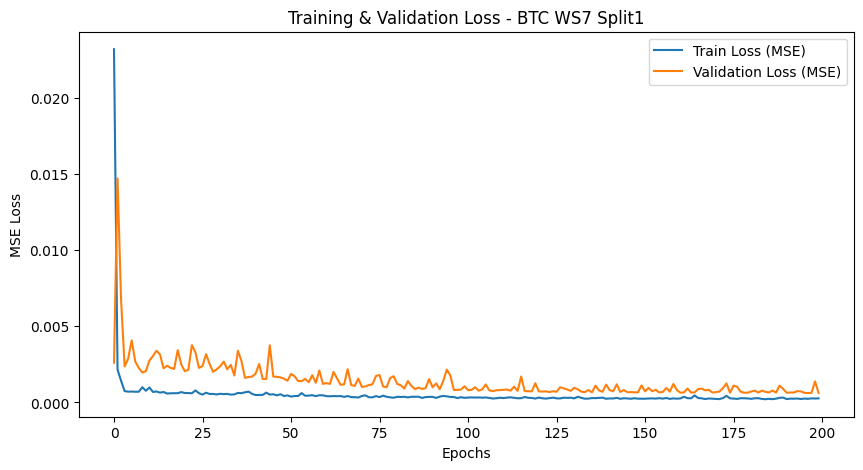

[BTC - WS7 - Split 1] Best Model saved
Avg Train Loss: 0.0005, Avg Validation Loss: 0.0014

=== Training BTC (WS7) on Split 2 ===


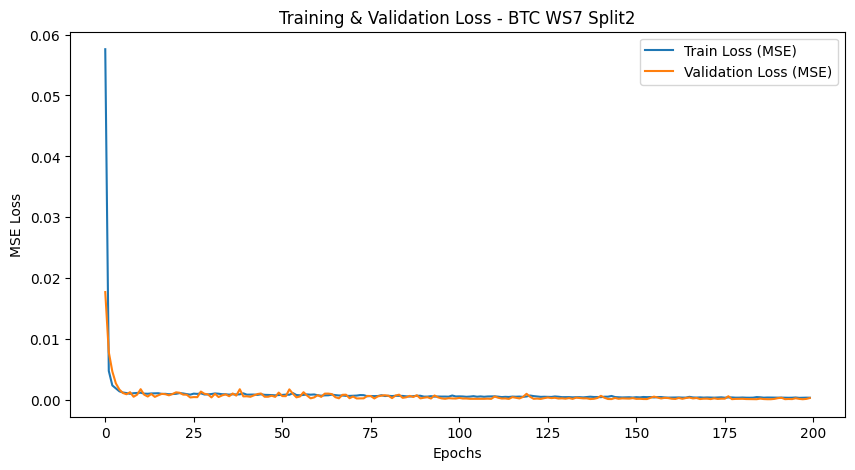

[BTC - WS7 - Split 2] Best Model saved
Avg Train Loss: 0.0010, Avg Validation Loss: 0.0007

=== Training BTC (WS7) on Split 3 ===


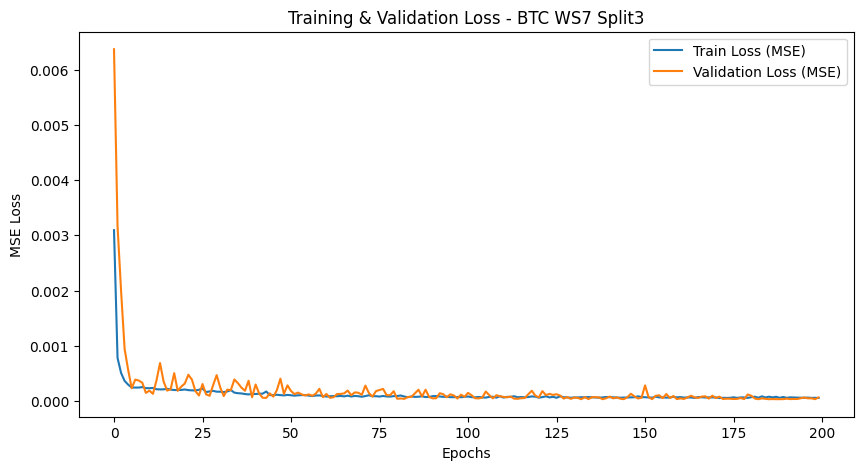

[BTC - WS7 - Split 3] Best Model saved
Avg Train Loss: 0.0001, Avg Validation Loss: 0.0002

=== Training BTC (WS7) on Split 4 ===


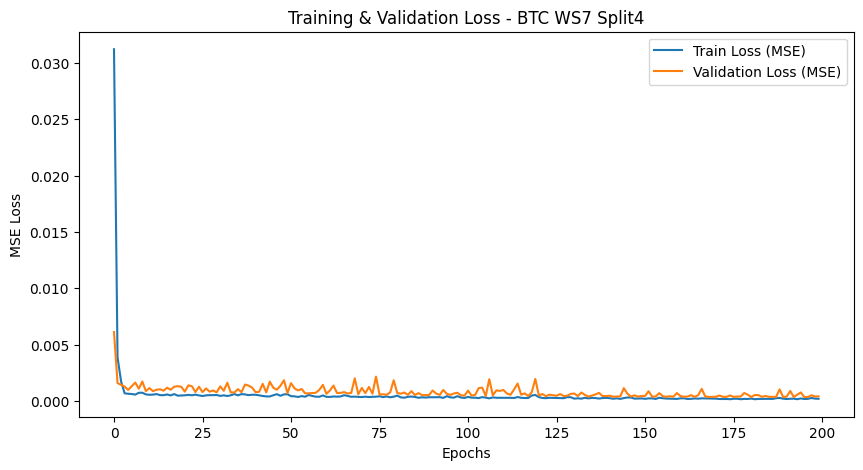

[BTC - WS7 - Split 4] Best Model saved
Avg Train Loss: 0.0005, Avg Validation Loss: 0.0008


In [66]:
perform_rwcv('btc', 7, best_params_btc_7, dataframes_btc, btc_scaler, save_dir="/kaggle/working/lstm")

#### ETH

In [67]:
# Fungsi untuk mendefinisikan Objective untuk optimasi Optuna
def objective_eth_split(trial, split_idx, asset, window_size):
    lstm_units1 = trial.suggest_categorical('lstm_units1', [32, 64, 128])
    lstm_units2 = trial.suggest_categorical('lstm_units2', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [100, 200, 300])

    # Load dataset sesuai split
    train_X = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_train_X']
    train_y = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_train_y']
    val_X = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_val_X']
    val_y = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_val_y']

    # Build model
    model = build_lstm_model(
        input_shape=(train_X.shape[1], 1),
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        lstm_units1=lstm_units1,
        lstm_units2=lstm_units2,
        dense_units=dense_units
    )

    # Training model
    history = model.fit(
        train_X, train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluation using validation data
    val_predictions = model.predict(val_X)
    val_mse = mean_squared_error(val_y, val_predictions)
    return val_mse

In [68]:
def optimize_split_2(asset, window_size):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    print(f"Optimizing {asset} {window_size} - Split 2")
    optimization_start_time = log_time_progress(f"Starting Optuna optimization for {asset} {window_size} - Split 2")
    study.optimize(lambda trial: objective_eth_split(trial, 2, asset, window_size), n_trials=50)
    best_params = study.best_params
    print(f"Best params for {asset} {window_size} - Split 2:", best_params)
    return best_params

In [69]:
# Optimasi untuk split 2
best_params_eth_7 = optimize_split_2('ETH', 'ws7')

[I 2025-03-05 14:25:26,652] A new study created in memory with name: no-name-c564268f-d4d9-49e1-89cc-01b4fd946e44


Optimizing ETH ws7 - Split 2
Starting Optuna optimization for ETH ws7 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:25:30,379] Trial 0 finished with value: 0.02504886917139721 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.02504886917139721.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:25:34,029] Trial 1 finished with value: 0.01396124071351293 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.01396124071351293.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:25:37,008] Trial 2 finished with value: 0.05710811944275723 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.01396124071351293.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:25:40,366] Trial 3 finished with value: 0.0858387780575451 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 1 with value: 0.01396124071351293.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:25:43,315] Trial 4 finished with value: 0.13253937607841507 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.01396124071351293.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:25:46,251] Trial 5 finished with value: 7.7165021125438 and parameters: {'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 1 with value: 0.01396124071351293.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:25:49,428] Trial 6 finished with value: 0.0056817502609795185 and parameters: {'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.0056817502609795185.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:25:52,627] Trial 7 finished with value: 0.14597100696467732 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 6 with value: 0.0056817502609795185.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:25:55,819] Trial 8 finished with value: 0.04546279262846014 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 6 with value: 0.0056817502609795185.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:25:58,777] Trial 9 finished with value: 0.004621635723787928 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.004621635723787928.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-03-05 14:26:01,780] Trial 10 finished with value: 0.00451156723903464 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 10 with value: 0.00451156723903464.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:26:04,763] Trial 11 finished with value: 0.044684433069583314 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 10 with value: 0.00451156723903464.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:26:07,724] Trial 12 finished with value: 0.14251186973751084 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 10 with value: 0.00451156723903464.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


[I 2025-03-05 14:26:10,826] Trial 13 finished with value: 0.0032472791919805327 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:26:13,857] Trial 14 finished with value: 0.038297087941878145 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:26:16,867] Trial 15 finished with value: 0.0821023824444677 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-03-05 14:26:20,608] Trial 16 finished with value: 0.031141840688249572 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:26:23,660] Trial 17 finished with value: 0.09349566771938471 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-03-05 14:26:26,688] Trial 18 finished with value: 0.12032340138203852 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2025-03-05 14:26:30,348] Trial 19 finished with value: 0.04839594637673203 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:26:33,342] Trial 20 finished with value: 0.02558258636518987 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:26:36,308] Trial 21 finished with value: 0.037500987595936515 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:26:39,328] Trial 22 finished with value: 0.01435147717838929 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-03-05 14:26:42,455] Trial 23 finished with value: 0.015010801854616306 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:26:45,519] Trial 24 finished with value: 0.07327852408644307 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 13 with value: 0.0032472791919805327.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:26:48,563] Trial 25 finished with value: 0.0031292531549904625 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:26:51,594] Trial 26 finished with value: 0.014871875918465645 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:26:54,562] Trial 27 finished with value: 0.0048378152888523445 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:26:57,824] Trial 28 finished with value: 0.4905457759758622 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:27:01,572] Trial 29 finished with value: 0.023149947358554163 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-03-05 14:27:05,303] Trial 30 finished with value: 0.011519159971938782 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-03-05 14:27:08,284] Trial 31 finished with value: 0.026840240521502294 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:27:11,345] Trial 32 finished with value: 0.004928492860377615 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:27:14,469] Trial 33 finished with value: 0.1556297628237192 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:27:17,494] Trial 34 finished with value: 0.08949045544778783 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-03-05 14:27:20,543] Trial 35 finished with value: 0.003247045205661451 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:27:23,618] Trial 36 finished with value: 0.11389463779100463 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:27:27,386] Trial 37 finished with value: 0.007510980731018712 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2025-03-05 14:27:30,756] Trial 38 finished with value: 0.11649118092487595 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2025-03-05 14:27:33,758] Trial 39 finished with value: 0.1047065191931914 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


[I 2025-03-05 14:27:46,024] Trial 40 finished with value: 0.03455726949174304 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2025-03-05 14:27:49,384] Trial 41 finished with value: 0.006773333797543341 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 14:27:52,655] Trial 42 finished with value: 0.008742900185033752 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:27:55,843] Trial 43 finished with value: 0.003275486211193521 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:27:59,300] Trial 44 finished with value: 0.015931908919552606 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 14:28:02,520] Trial 45 finished with value: 2.5143837405420673 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:28:05,630] Trial 46 finished with value: 0.011347124561734164 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:28:08,711] Trial 47 finished with value: 0.03455444553692108 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2025-03-05 14:28:11,832] Trial 48 finished with value: 0.14682989980222638 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 25 with value: 0.0031292531549904625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-03-05 14:28:15,205] Trial 49 finished with value: 0.11542781112710777 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 25 with value: 0.0031292531549904625.


Best params for ETH ws7 - Split 2: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}


In [70]:
best_params_eth_7 = {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 
                     'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}

In [71]:
# Optimasi untuk split 2
best_params_eth_14 = optimize_split_2('ETH', 'ws14')

[I 2025-03-05 14:30:43,776] A new study created in memory with name: no-name-eb441444-8b4c-4b03-9ef6-d5dfc606900c


Optimizing ETH ws14 - Split 2
Starting Optuna optimization for ETH ws14 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-03-05 14:30:47,588] Trial 0 finished with value: 0.021002657606288933 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.021002657606288933.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:30:51,470] Trial 1 finished with value: 0.010726864651203162 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.010726864651203162.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:30:54,638] Trial 2 finished with value: 0.079991868159719 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.010726864651203162.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:30:58,000] Trial 3 finished with value: 0.15742115897164166 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 1 with value: 0.010726864651203162.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:31:01,091] Trial 4 finished with value: 0.029549139027303505 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.010726864651203162.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:31:04,150] Trial 5 finished with value: 0.08571502856873174 and parameters: {'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 1 with value: 0.010726864651203162.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:31:07,429] Trial 6 finished with value: 0.0397099596855524 and parameters: {'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 1 with value: 0.010726864651203162.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-03-05 14:31:10,729] Trial 7 finished with value: 0.07861795614877641 and parameters: {'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 1 with value: 0.010726864651203162.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:31:13,986] Trial 8 finished with value: 0.003268292180191389 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:31:16,955] Trial 9 finished with value: 0.05302647902179973 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:31:20,226] Trial 10 finished with value: 0.048870499995004826 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-03-05 14:31:24,029] Trial 11 finished with value: 0.0880121842087832 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:31:27,951] Trial 12 finished with value: 0.05395381324711158 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:31:31,722] Trial 13 finished with value: 0.03195991641939752 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:31:34,992] Trial 14 finished with value: 0.02575322497936787 and parameters: {'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:31:38,680] Trial 15 finished with value: 0.01665826437357674 and parameters: {'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:31:42,453] Trial 16 finished with value: 0.004672105857589689 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:31:45,670] Trial 17 finished with value: 0.05507161821575164 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:31:48,865] Trial 18 finished with value: 0.057415183759561256 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:31:52,536] Trial 19 finished with value: 0.006248222456425054 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:31:56,227] Trial 20 finished with value: 0.004011291359889653 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 8 with value: 0.003268292180191389.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:32:00,034] Trial 21 finished with value: 0.0026606475620097386 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0026606475620097386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:32:03,768] Trial 22 finished with value: 0.002873965422264068 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0026606475620097386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:32:07,420] Trial 23 finished with value: 0.006213675884430731 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0026606475620097386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:32:11,083] Trial 24 finished with value: 0.0032842900320973313 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0026606475620097386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:32:14,267] Trial 25 finished with value: 0.11038286653889966 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 21 with value: 0.0026606475620097386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:32:17,950] Trial 26 finished with value: 0.004568256595201258 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 21 with value: 0.0026606475620097386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:32:21,696] Trial 27 finished with value: 0.003024194358035699 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0026606475620097386.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-03-05 14:32:25,396] Trial 28 finished with value: 0.0025150417679491374 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 28 with value: 0.0025150417679491374.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


[I 2025-03-05 14:32:29,199] Trial 29 finished with value: 0.0031351997779608632 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 28 with value: 0.0025150417679491374.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-03-05 14:32:33,003] Trial 30 finished with value: 0.0135652586950203 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 28 with value: 0.0025150417679491374.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:32:36,732] Trial 31 finished with value: 0.0032658441578815654 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 28 with value: 0.0025150417679491374.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 14:32:40,567] Trial 32 finished with value: 0.002730380388584607 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 28 with value: 0.0025150417679491374.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:32:44,402] Trial 33 finished with value: 0.00235216904238211 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-03-05 14:32:48,189] Trial 34 finished with value: 0.006035499928150448 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2025-03-05 14:32:51,958] Trial 35 finished with value: 0.0045523749608410834 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 14:32:54,969] Trial 36 finished with value: 0.012932012835133188 and parameters: {'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:32:58,647] Trial 37 finished with value: 0.012146758840122087 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-03-05 14:33:01,877] Trial 38 finished with value: 0.11522902966822766 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-03-05 14:33:05,512] Trial 39 finished with value: 0.0025855481248819446 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-03-05 14:33:09,174] Trial 40 finished with value: 0.01083574379692997 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:33:12,873] Trial 41 finished with value: 0.005312588801316229 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-03-05 14:33:16,628] Trial 42 finished with value: 0.0040669892643728014 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-03-05 14:33:20,339] Trial 43 finished with value: 0.00412985219143498 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2025-03-05 14:33:23,381] Trial 44 finished with value: 0.05294193562923823 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:33:27,101] Trial 45 finished with value: 0.004855640772679003 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2025-03-05 14:33:30,855] Trial 46 finished with value: 0.006684402214659601 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-03-05 14:33:34,923] Trial 47 finished with value: 0.011597486636254426 and parameters: {'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 200}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-03-05 14:33:38,689] Trial 48 finished with value: 0.0033152391988044037 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 33 with value: 0.00235216904238211.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-03-05 14:33:41,724] Trial 49 finished with value: 0.004790495143139053 and parameters: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 33 with value: 0.00235216904238211.


Best params for ETH ws14 - Split 2: {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


In [72]:
best_params_eth_14 = {'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 
                      'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


=== Training ETH (WS14) on Split 1 ===


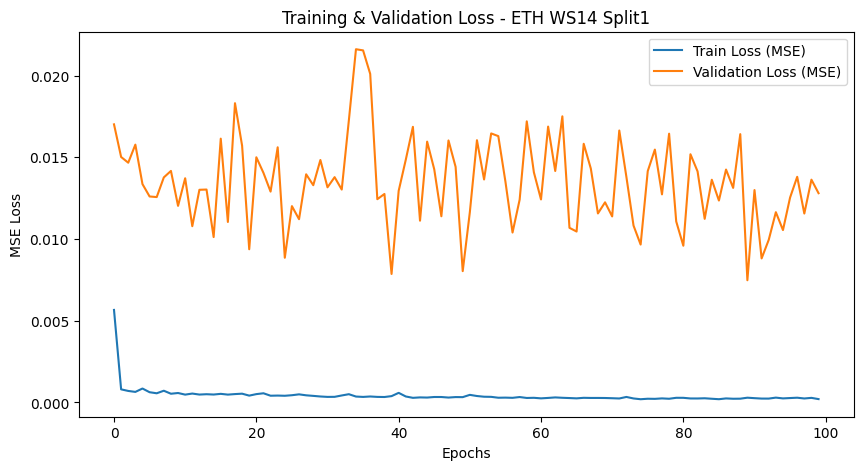

[ETH - WS14 - Split 1] Best Model saved
Avg Train Loss: 0.0004, Avg Validation Loss: 0.0135

=== Training ETH (WS14) on Split 2 ===


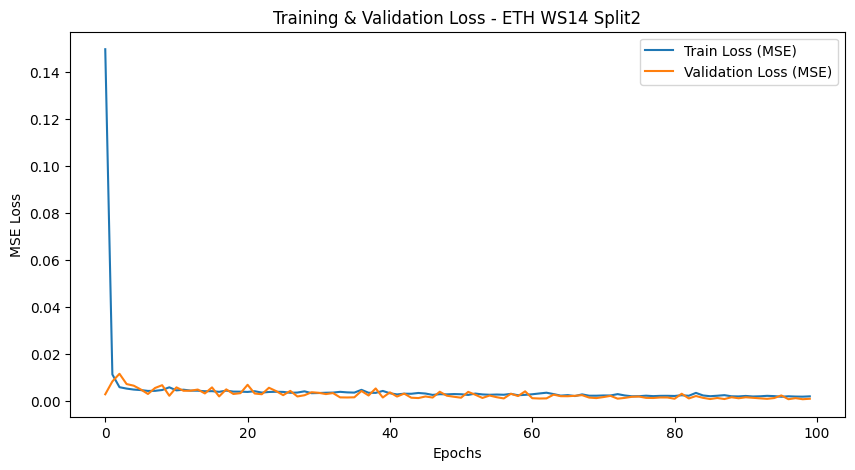

[ETH - WS14 - Split 2] Best Model saved
Avg Train Loss: 0.0046, Avg Validation Loss: 0.0026

=== Training ETH (WS14) on Split 3 ===


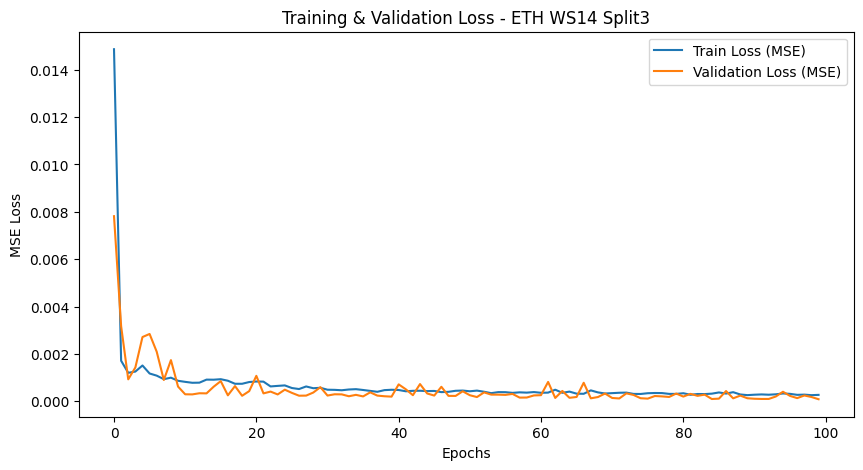

[ETH - WS14 - Split 3] Best Model saved
Avg Train Loss: 0.0007, Avg Validation Loss: 0.0005

=== Training ETH (WS14) on Split 4 ===


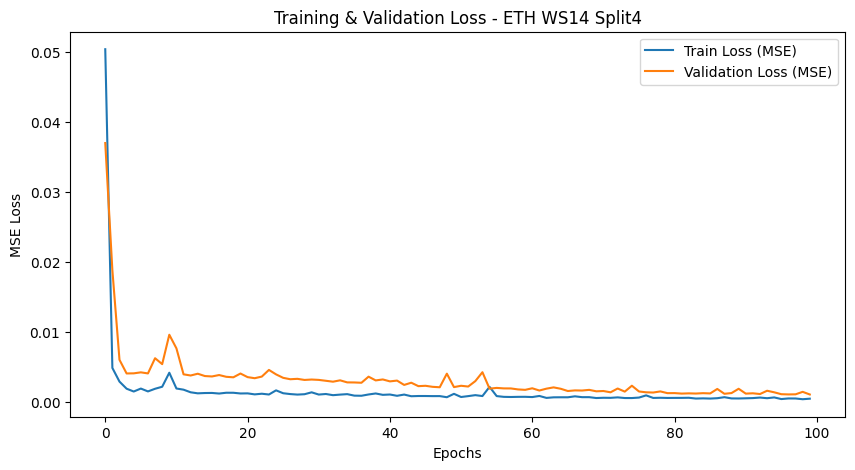

[ETH - WS14 - Split 4] Best Model saved
Avg Train Loss: 0.0015, Avg Validation Loss: 0.0032


In [73]:
perform_rwcv('eth', 14, best_params_eth_14, dataframes_eth, eth_scaler,  save_dir="/kaggle/working/lstm")


Loading best model: /kaggle/working/lstm/best_model_btc_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Confusion Matrix
[[36 47]
 [39 53]]
[Test Evaluation] BTC WS7 Split 2
MAPE: 2.3439%, DA: 50.8571%, RMSE: 2368.9323


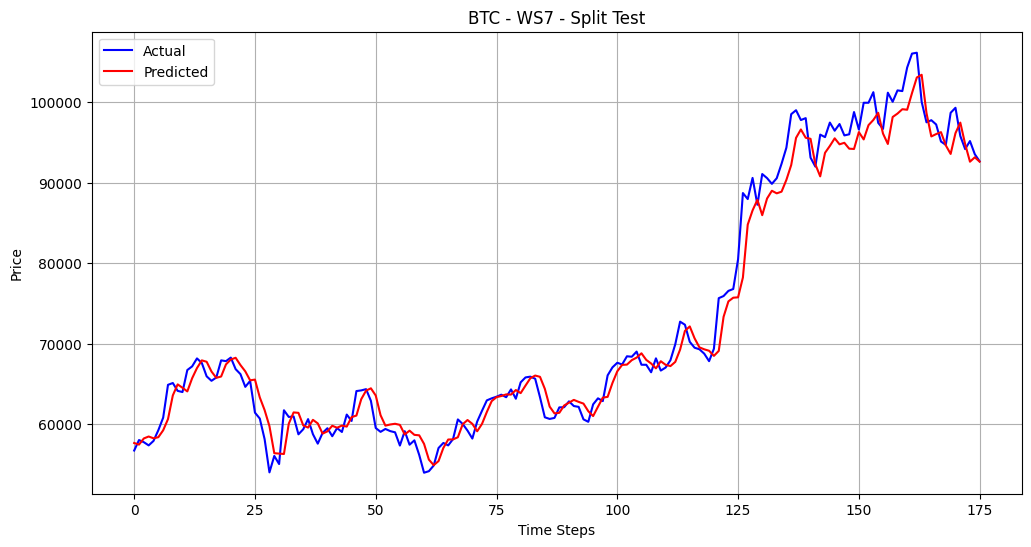

In [74]:
evaluate_test_model("btc", 7, split_idx=2, dataframes=dataframes_btc, scaler=btc_scaler, save_dir="/kaggle/working/lstm")


Loading best model: /kaggle/working/lstm/best_model_eth_14_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Confusion Matrix
[[36 46]
 [43 43]]
[Test Evaluation] ETH WS14 Split 2
MAPE: 3.5121%, DA: 47.0238%, RMSE: 137.4961


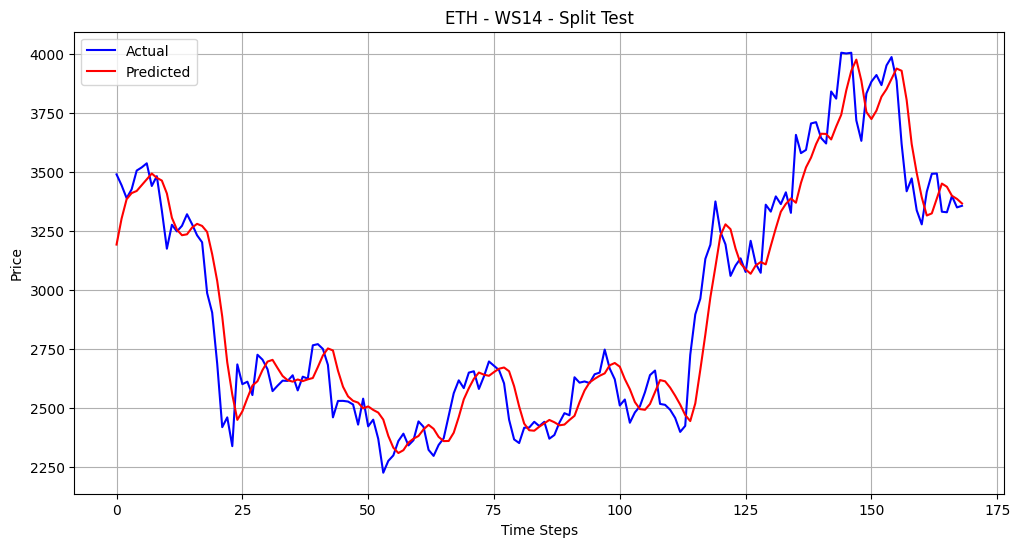

In [80]:
evaluate_test_model("eth", 14, split_idx=2, dataframes=dataframes_eth, scaler=eth_scaler, save_dir="/kaggle/working/lstm")

## **BiLSTM**

In [82]:
save_dir = "/kaggle/working/bilstm"
os.makedirs(save_dir, exist_ok=True)

In [83]:
# Fungsi untuk menambahkan ModelCheckpoint
def get_model_checkpoint(asset, window_size, split_idx):
    # Tentukan lokasi penyimpanan model terbaik
    model_filename = (f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras")
    model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', save_best_only=True)
    return model_checkpoint

In [84]:
# Fungsi untuk membangun Model BiLSTM
def build_bilstm_model(input_shape, learning_rate, dropout_rate, bilstm_units1, bilstm_units2, dense_units):
    model = Sequential()

    # BiLSTM Layers
    model.add(Bidirectional(LSTM(bilstm_units1, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(bilstm_units2)))

    # Dense Layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))  # Lapisan output

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [85]:
def train_and_validate_split(
    asset, window_size, train_data, val_data, best_params, split_idx, scaler, save_dir
):

    train_X, train_y = train_data
    val_X, val_y = val_data

    # Bangun model dengan hyperparameters terbaik
    model = build_bilstm_model(
        input_shape=(train_X.shape[1], 1),
        learning_rate=best_params['learning_rate'],
        dropout_rate=best_params['dropout_rate'],
        bilstm_units1=best_params['bilstm_units1'],
        bilstm_units2=best_params['bilstm_units2'],
        dense_units=best_params['dense_units']
    )

    # Checkpoint
    model_checkpoint = get_model_checkpoint(asset, window_size, split_idx)
    history = model.fit(
        train_X, train_y,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[model_checkpoint]
    )

    # Plot Loss (MSE) Training & Validation
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title(f'Training & Validation Loss - {asset.upper()} WS{window_size} Split{split_idx}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    # Hitung rata-rata loss selama pelatihan
    avg_train_loss = np.mean(history.history['loss'])
    avg_val_loss = np.mean(history.history['val_loss'])

    print(f"[{asset.upper()} - WS{window_size} - Split {split_idx}] Best Model saved")
    print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}")

    model.save(f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras")
    return model

In [86]:
def perform_rwcv(asset, window_size, best_params, dataframes, scaler, save_dir):

    window_size_str = f'ws{window_size}'

    for split_idx in range(1, 5):
        print(f"\n=== Training {asset.upper()} (WS{window_size}) on Split {split_idx} ===")

        # Ambil data train & val
        train_X = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_train_X')
        train_y = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_train_y')
        val_X = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_val_X')
        val_y = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_val_y')

        # Latih & Validasi
        train_and_validate_split(
            asset, window_size,
            (train_X, train_y), (val_X, val_y),
            best_params, split_idx, scaler,
            save_dir
        )

In [88]:
def evaluate_test_model(asset, window_size, split_idx, dataframes, scaler, save_dir):

    window_size_str = f'ws{window_size}'

    # Path model terbaik (sesuai naming checkpoint)
    model_filename = f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras"

    print(f"\nLoading best model: {model_filename}")
    model = load_model(model_filename)

    # Ambil data test
    test_X = dataframes.get(f'{asset.lower()}_{window_size_str}_test_X')
    test_y = dataframes.get(f'{asset.lower()}_{window_size_str}_test_y')

    # Prediksi
    predictions = model.predict(test_X)

    # Inverse transform
    test_y_original = scaler.inverse_transform(test_y.values.reshape(-1, 1)).flatten()
    predictions_original = scaler.inverse_transform(predictions).flatten()

    # Hitung metrik
    mape = evaluate_mape(test_y_original, predictions_original)
    da = evaluate_direction_accuracy(test_y_original, predictions_original)
    rmse = evaluate_rmse(test_y_original, predictions_original)

    print(f"[Test Evaluation] {asset.upper()} WS{window_size} Split {split_idx}")
    print(f"MAPE: {mape:.4f}%, DA: {da:.4f}%, RMSE: {rmse:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_y_original, label='Actual', color='blue')
    plt.plot(predictions_original, label='Predicted', color='red')
    plt.title(f"{asset.upper()} - WS{window_size} - Split Test")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

#### BTC

In [90]:
# Fungsi untuk mendefinisikan Objective untuk optimasi Optuna
def objective_btc_split(trial, split_idx, asset, window_size):
    bilstm_units1 = trial.suggest_categorical('bilstm_units1', [32, 64, 128])
    bilstm_units2 = trial.suggest_categorical('bilstm_units2', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [100, 200, 300])

    # Load dataset sesuai split
    train_X = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_train_X']
    train_y = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_train_y']
    val_X = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_val_X']
    val_y = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_val_y']

    # Build model
    model = build_bilstm_model(
        input_shape=(train_X.shape[1], 1),
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        bilstm_units1=bilstm_units1,
        bilstm_units2=bilstm_units2,
        dense_units=dense_units
    )

    # Training model
    history = model.fit(
        train_X, train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluation using validation data
    val_predictions = model.predict(val_X)
    val_mse = mean_squared_error(val_y, val_predictions)
    return val_mse

In [91]:
def optimize_split_2(asset, window_size):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    print(f"Optimizing {asset} {window_size} - Split 2")
    optimization_start_time = log_time_progress(f"Starting Optuna optimization for {asset} {window_size} - Split 2")
    study.optimize(lambda trial: objective_btc_split(trial, 2, asset, window_size), n_trials=50)
    best_params = study.best_params
    print(f"Best params for {asset} {window_size} - Split 2:", best_params)
    return best_params

In [92]:
# Optimasi untuk split 2
best_params_btc_7 = optimize_split_2('BTC', 'ws7')

[I 2025-03-05 14:40:37,506] A new study created in memory with name: no-name-7909f695-ce6a-4251-9497-b6b48464197b


Optimizing BTC ws7 - Split 2
Starting Optuna optimization for BTC ws7 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2025-03-05 14:40:43,193] Trial 0 finished with value: 0.002735716751632689 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.002735716751632689.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 14:40:48,878] Trial 1 finished with value: 0.0033404533894269067 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 0 with value: 0.002735716751632689.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step


[I 2025-03-05 14:40:53,617] Trial 2 finished with value: 0.020327795336191286 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 0 with value: 0.002735716751632689.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 14:40:58,697] Trial 3 finished with value: 1.299779530271162 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 0 with value: 0.002735716751632689.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-03-05 14:41:03,407] Trial 4 finished with value: 0.0014947037825077736 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0014947037825077736.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 14:41:08,071] Trial 5 finished with value: 81.03406826923946 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 4 with value: 0.0014947037825077736.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 14:41:13,183] Trial 6 finished with value: 0.04139342282494246 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 4 with value: 0.0014947037825077736.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-03-05 14:41:18,248] Trial 7 finished with value: 0.0066305319843865135 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 4 with value: 0.0014947037825077736.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-03-05 14:41:23,298] Trial 8 finished with value: 0.01850910949804834 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 4 with value: 0.0014947037825077736.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-03-05 14:41:28,015] Trial 9 finished with value: 0.013442528909737581 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0014947037825077736.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-03-05 14:41:32,746] Trial 10 finished with value: 0.03959959135262384 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0014947037825077736.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-03-05 14:41:38,453] Trial 11 finished with value: 0.0007990727354540201 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 11 with value: 0.0007990727354540201.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-03-05 14:41:44,210] Trial 12 finished with value: 0.0006361355257768953 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 12 with value: 0.0006361355257768953.


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step


[I 2025-03-05 14:42:00,471] Trial 13 finished with value: 0.0006293436575830238 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.0006293436575830238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 14:42:06,690] Trial 14 finished with value: 0.0009476645443301041 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.0006293436575830238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-03-05 14:42:12,799] Trial 15 finished with value: 0.0009589080739726951 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.0006293436575830238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 14:42:18,811] Trial 16 finished with value: 0.0006755719151248187 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.0006293436575830238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-03-05 14:42:24,828] Trial 17 finished with value: 0.0008019546490676864 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 13 with value: 0.0006293436575830238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step


[I 2025-03-05 14:42:30,989] Trial 18 finished with value: 0.0005888768210167231 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-03-05 14:42:36,919] Trial 19 finished with value: 0.001237896045249064 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 14:42:42,868] Trial 20 finished with value: 0.0006078271459255139 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 14:42:48,833] Trial 21 finished with value: 0.006154131201043051 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 14:42:54,803] Trial 22 finished with value: 0.009710703075709766 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step


[I 2025-03-05 14:43:00,992] Trial 23 finished with value: 0.001115091547257564 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-03-05 14:43:06,989] Trial 24 finished with value: 0.0005900871708298574 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-03-05 14:43:12,958] Trial 25 finished with value: 0.0006726098152033102 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 14:43:18,775] Trial 26 finished with value: 0.0006654094492657902 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-03-05 14:43:24,604] Trial 27 finished with value: 0.003256301234202478 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-03-05 14:43:29,671] Trial 28 finished with value: 0.02665418085864291 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 18 with value: 0.0005888768210167231.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-03-05 14:43:40,717] Trial 29 finished with value: 0.00015593217359314817 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 14:43:46,565] Trial 30 finished with value: 0.015354991378017924 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:43:52,462] Trial 31 finished with value: 0.0015123291152419477 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-03-05 14:43:58,222] Trial 32 finished with value: 0.0035134572599210155 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 14:44:04,089] Trial 33 finished with value: 0.0127960481698173 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-03-05 14:44:09,816] Trial 34 finished with value: 0.005000185733552722 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 14:44:15,558] Trial 35 finished with value: 0.11596214913385125 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 14:44:20,154] Trial 36 finished with value: 0.026757674968668634 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-03-05 14:44:25,891] Trial 37 finished with value: 0.0005909964116111437 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-03-05 14:44:30,955] Trial 38 finished with value: 0.0004755912913844972 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-03-05 14:44:36,088] Trial 39 finished with value: 0.02759504334754561 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-03-05 14:44:41,156] Trial 40 finished with value: 0.06113382229939935 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 14:44:46,191] Trial 41 finished with value: 0.0004365316996309608 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-03-05 14:44:51,264] Trial 42 finished with value: 0.03682719766115754 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-03-05 14:44:56,282] Trial 43 finished with value: 0.006125830181642662 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-03-05 14:45:01,383] Trial 44 finished with value: 0.0014631598585660864 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2025-03-05 14:45:06,510] Trial 45 finished with value: 0.005385915432124784 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 14:45:11,586] Trial 46 finished with value: 0.37881210522027253 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-03-05 14:45:16,246] Trial 47 finished with value: 0.05433879497408034 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-03-05 14:45:21,303] Trial 48 finished with value: 0.007266386271551596 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 29 with value: 0.00015593217359314817.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 14:45:26,345] Trial 49 finished with value: 8.269661825235792 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 29 with value: 0.00015593217359314817.


Best params for BTC ws7 - Split 2: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}


In [93]:
best_params_btc_7 = {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 
                     'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}

In [94]:
# Optimasi untuk split 2
best_params_btc_14 = optimize_split_2('BTC', 'ws14')

[I 2025-03-05 14:46:39,904] A new study created in memory with name: no-name-d617bd44-1ba1-4ab9-afc0-14a1e720f2b9


Optimizing BTC ws14 - Split 2
Starting Optuna optimization for BTC ws14 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:46:45,865] Trial 0 finished with value: 0.021682584070681837 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.021682584070681837.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:46:51,770] Trial 1 finished with value: 0.022501845834312237 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 0 with value: 0.021682584070681837.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 14:46:56,585] Trial 2 finished with value: 0.018980611412495588 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.018980611412495588.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:47:01,708] Trial 3 finished with value: 0.8034941702259898 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.018980611412495588.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-03-05 14:47:06,435] Trial 4 finished with value: 0.0006829613594680891 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 14:47:11,184] Trial 5 finished with value: 9.225692256811033 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 14:47:16,389] Trial 6 finished with value: 0.0014873380255096488 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:47:21,513] Trial 7 finished with value: 0.32728116511854916 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-03-05 14:47:26,677] Trial 8 finished with value: 0.0013547175203977222 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-03-05 14:47:31,330] Trial 9 finished with value: 0.04721862091305131 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2025-03-05 14:47:36,017] Trial 10 finished with value: 0.008509527965254789 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-03-05 14:47:41,167] Trial 11 finished with value: 0.013419853977606283 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2025-03-05 14:47:45,922] Trial 12 finished with value: 0.003951350932165313 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 14:47:51,093] Trial 13 finished with value: 0.025625711605793317 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 14:47:56,847] Trial 14 finished with value: 0.0007052232978718851 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-03-05 14:48:02,741] Trial 15 finished with value: 0.0008052102160242985 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 14:48:08,572] Trial 16 finished with value: 0.0006851843211786169 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2025-03-05 14:48:14,418] Trial 17 finished with value: 0.001153733753066838 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 14:48:20,329] Trial 18 finished with value: 0.0006889800047057218 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 14:48:25,021] Trial 19 finished with value: 0.009476267730723454 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-03-05 14:48:29,729] Trial 20 finished with value: 0.0018307590344941898 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-03-05 14:48:35,530] Trial 21 finished with value: 0.003128935526928982 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-03-05 14:48:41,354] Trial 22 finished with value: 0.0017462442209870077 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-03-05 14:48:47,134] Trial 23 finished with value: 0.0007063369416037071 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-03-05 14:48:52,880] Trial 24 finished with value: 0.001894204479859401 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-03-05 14:48:58,780] Trial 25 finished with value: 0.009851429823179794 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


[I 2025-03-05 14:49:17,524] Trial 26 finished with value: 0.0006952344818968331 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 14:49:22,731] Trial 27 finished with value: 0.012318430667649281 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-03-05 14:49:28,890] Trial 28 finished with value: 0.8048088391100043 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-03-05 14:49:35,145] Trial 29 finished with value: 0.0051221962323113246 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-03-05 14:49:40,040] Trial 30 finished with value: 1.5853307994076473 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-03-05 14:49:46,112] Trial 31 finished with value: 0.0007282477774330567 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 14:49:52,370] Trial 32 finished with value: 0.0014736759118192798 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 14:49:58,378] Trial 33 finished with value: 0.0022804785878117436 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 14:50:04,491] Trial 34 finished with value: 0.005907476741031939 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-03-05 14:50:10,489] Trial 35 finished with value: 0.0013757064433263585 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:50:16,429] Trial 36 finished with value: 0.007474427619506393 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:50:21,359] Trial 37 finished with value: 17.597500873022124 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 14:50:27,363] Trial 38 finished with value: 0.005546645318740322 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-03-05 14:50:32,637] Trial 39 finished with value: 0.005010764621871701 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:50:37,403] Trial 40 finished with value: 1.0214326427488423 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-03-05 14:50:43,367] Trial 41 finished with value: 0.0006943227528043107 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-03-05 14:50:49,299] Trial 42 finished with value: 0.0007466595648614376 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 4 with value: 0.0006829613594680891.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 14:50:55,358] Trial 43 finished with value: 0.0006444654702434294 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 43 with value: 0.0006444654702434294.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 14:51:01,192] Trial 44 finished with value: 0.0008662796202333677 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 43 with value: 0.0006444654702434294.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-03-05 14:51:06,388] Trial 45 finished with value: 0.0023986461330590693 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 43 with value: 0.0006444654702434294.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-03-05 14:51:12,264] Trial 46 finished with value: 0.0009176225079662245 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 43 with value: 0.0006444654702434294.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 14:51:16,967] Trial 47 finished with value: 0.031756104807562496 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100}. Best is trial 43 with value: 0.0006444654702434294.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:51:22,852] Trial 48 finished with value: 0.0007316708989787515 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 43 with value: 0.0006444654702434294.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 14:51:28,057] Trial 49 finished with value: 0.003876533081273449 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 43 with value: 0.0006444654702434294.


Best params for BTC ws14 - Split 2: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


In [95]:
best_params_btc_14 = {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 
                      'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


=== Training BTC (WS7) on Split 1 ===


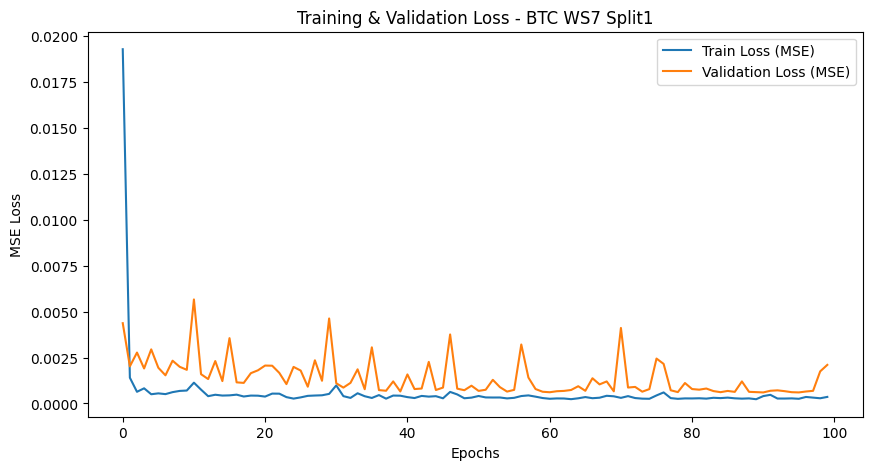

[BTC - WS7 - Split 1] Best Model saved
Avg Train Loss: 0.0006, Avg Validation Loss: 0.0014

=== Training BTC (WS7) on Split 2 ===


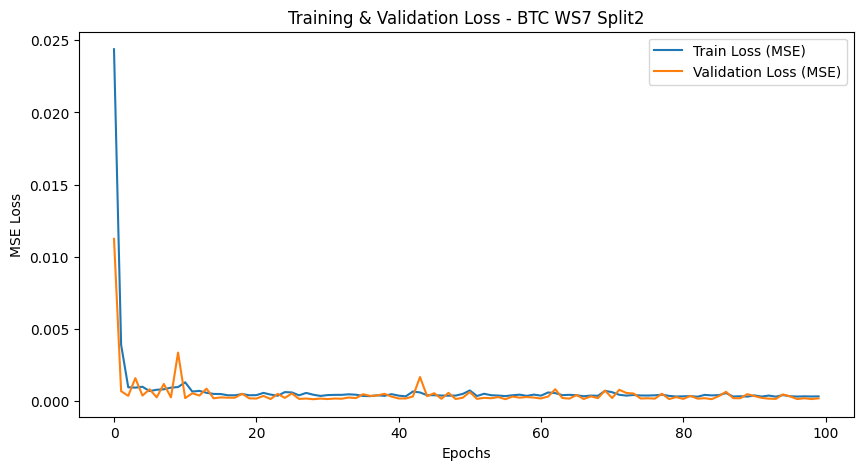

[BTC - WS7 - Split 2] Best Model saved
Avg Train Loss: 0.0008, Avg Validation Loss: 0.0005

=== Training BTC (WS7) on Split 3 ===


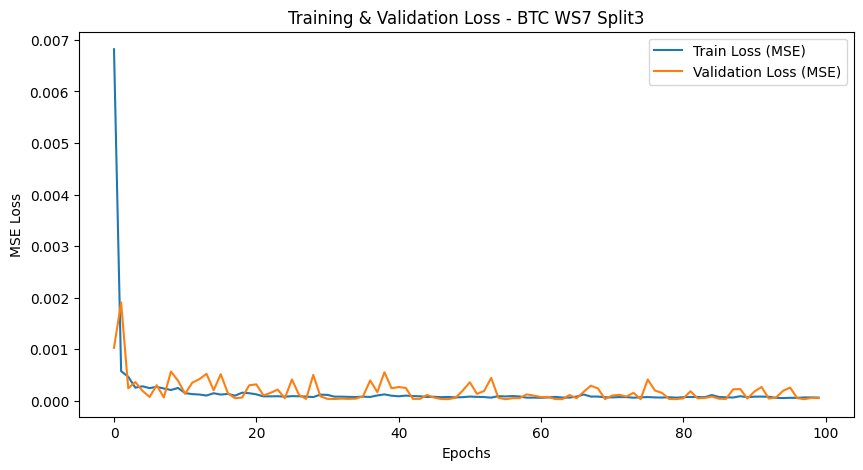

[BTC - WS7 - Split 3] Best Model saved
Avg Train Loss: 0.0002, Avg Validation Loss: 0.0002

=== Training BTC (WS7) on Split 4 ===


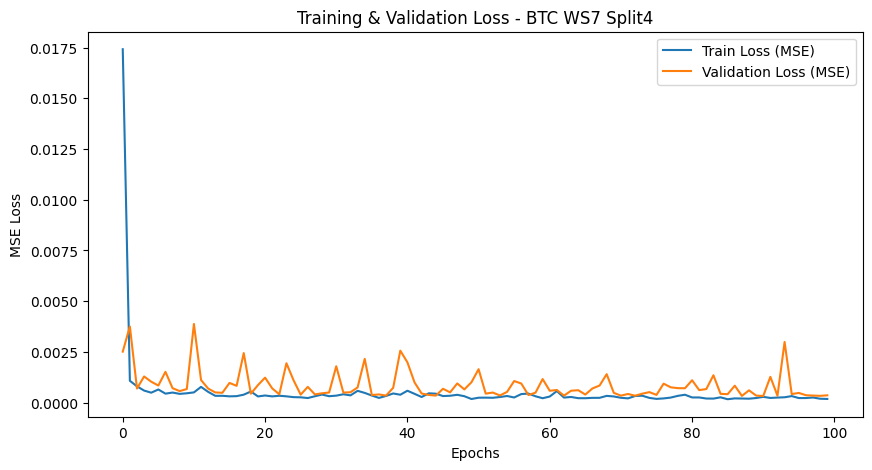

[BTC - WS7 - Split 4] Best Model saved
Avg Train Loss: 0.0005, Avg Validation Loss: 0.0009


In [96]:
perform_rwcv('btc', 7, best_params_btc_7, dataframes_btc, btc_scaler, save_dir = "/kaggle/working/bilstm")

#### ETH

In [97]:
# Fungsi untuk mendefinisikan Objective untuk optimasi Optuna
def objective_eth_split(trial, split_idx, asset, window_size):
    bilstm_units1 = trial.suggest_categorical('bilstm_units1', [32, 64, 128])
    bilstm_units2 = trial.suggest_categorical('bilstm_units2', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [100, 200, 300])

    # Load dataset sesuai split
    train_X = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_train_X']
    train_y = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_train_y']
    val_X = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_val_X']
    val_y = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_val_y']

    # Build model
    model = build_bilstm_model(
        input_shape=(train_X.shape[1], 1),
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        bilstm_units1=bilstm_units1,
        bilstm_units2=bilstm_units2,
        dense_units=dense_units
    )

    # Training model
    history = model.fit(
        train_X, train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluation using validation data
    val_predictions = model.predict(val_X)
    val_mse = mean_squared_error(val_y, val_predictions)
    return val_mse

In [98]:
def optimize_split_2(asset, window_size):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    print(f"Optimizing {asset} {window_size} - Split 2")
    optimization_start_time = log_time_progress(f"Starting Optuna optimization for {asset} {window_size} - Split 2")
    study.optimize(lambda trial: objective_eth_split(trial, 2, asset, window_size), n_trials=50)
    best_params = study.best_params
    print(f"Best params for {asset} {window_size} - Split 2:", best_params)
    return best_params

In [99]:
# Optimasi untuk split 2
best_params_eth_7 = optimize_split_2('ETH', 'ws7')

[I 2025-03-05 14:55:10,682] A new study created in memory with name: no-name-2d3de9ef-6ca7-4804-a495-82bcb6362ac2


Optimizing ETH ws7 - Split 2
Starting Optuna optimization for ETH ws7 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 14:55:16,344] Trial 0 finished with value: 0.09749121659700272 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.09749121659700272.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-03-05 14:55:22,114] Trial 1 finished with value: 0.005650727994187655 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.005650727994187655.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-03-05 14:55:26,765] Trial 2 finished with value: 0.002258455777031743 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 14:55:31,803] Trial 3 finished with value: 1.069589078193784 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-03-05 14:55:36,390] Trial 4 finished with value: 0.04334338666867353 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 14:55:41,150] Trial 5 finished with value: 6.816069504031162 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-03-05 14:55:46,219] Trial 6 finished with value: 0.03276194214087306 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-03-05 14:55:51,271] Trial 7 finished with value: 0.9675153236787517 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 14:55:56,257] Trial 8 finished with value: 0.07879690022120878 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2025-03-05 14:56:00,922] Trial 9 finished with value: 0.005697043497787539 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2025-03-05 14:56:05,536] Trial 10 finished with value: 0.010156135451206723 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 14:56:11,507] Trial 11 finished with value: 0.0056876084173376595 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-03-05 14:56:17,237] Trial 12 finished with value: 0.00334482672261263 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-03-05 14:56:22,920] Trial 13 finished with value: 0.0024062589668771093 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-03-05 14:56:27,523] Trial 14 finished with value: 0.04241242827567332 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 14:56:33,331] Trial 15 finished with value: 0.005142749841800685 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-03-05 14:56:38,066] Trial 16 finished with value: 0.06785308143815783 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 14:56:44,008] Trial 17 finished with value: 0.0075880723086737475 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 14:56:49,661] Trial 18 finished with value: 0.0032013768002305825 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-03-05 14:56:54,297] Trial 19 finished with value: 0.11926389510929354 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-03-05 14:56:59,048] Trial 20 finished with value: 0.0042437510744730905 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 14:57:04,827] Trial 21 finished with value: 0.010680531827165333 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 2 with value: 0.002258455777031743.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-03-05 14:57:10,548] Trial 22 finished with value: 0.0019001076747169785 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.0019001076747169785.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-03-05 14:57:16,300] Trial 23 finished with value: 0.014011169647753353 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.0019001076747169785.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 14:57:21,980] Trial 24 finished with value: 0.006718115022340228 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.0019001076747169785.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 14:57:27,733] Trial 25 finished with value: 0.0015744760225891187 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 25 with value: 0.0015744760225891187.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 14:57:33,436] Trial 26 finished with value: 0.0034875416207437626 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 25 with value: 0.0015744760225891187.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-03-05 14:57:39,086] Trial 27 finished with value: 0.0014124901542095713 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 14:57:44,900] Trial 28 finished with value: 0.2277949430952081 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-03-05 14:57:50,616] Trial 29 finished with value: 0.0021070475400801793 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 14:57:56,287] Trial 30 finished with value: 0.08180691224794706 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-03-05 14:58:02,005] Trial 31 finished with value: 0.01165618394810443 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-03-05 14:58:07,717] Trial 32 finished with value: 0.0032827535049705535 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-03-05 14:58:13,415] Trial 33 finished with value: 0.0041669061392333555 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 14:58:19,158] Trial 34 finished with value: 0.011161330306894927 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-03-05 14:58:24,928] Trial 35 finished with value: 0.001471068355726254 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2025-03-05 14:58:30,830] Trial 36 finished with value: 0.005174806262501012 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-03-05 14:58:35,906] Trial 37 finished with value: 0.002723289270365855 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-03-05 14:58:41,653] Trial 38 finished with value: 0.1072422644350908 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 14:58:46,659] Trial 39 finished with value: 0.007437839368244588 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 14:58:52,466] Trial 40 finished with value: 0.0019032258409091838 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-03-05 14:58:58,146] Trial 41 finished with value: 0.006173010997126389 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-03-05 14:59:03,866] Trial 42 finished with value: 0.03335959731150834 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-03-05 14:59:09,574] Trial 43 finished with value: 0.029272187329443103 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step


[I 2025-03-05 14:59:30,142] Trial 44 finished with value: 0.037077442037200065 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-03-05 14:59:35,722] Trial 45 finished with value: 0.006406612429719454 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-03-05 14:59:41,901] Trial 46 finished with value: 0.015172403521033702 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 14:59:48,043] Trial 47 finished with value: 0.007322686132072229 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-03-05 14:59:54,238] Trial 48 finished with value: 0.006915282555522487 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 300}. Best is trial 27 with value: 0.0014124901542095713.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-03-05 15:00:00,265] Trial 49 finished with value: 0.0034248200289001113 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.0014124901542095713.


Best params for ETH ws7 - Split 2: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}


In [100]:
best_params_eth_7 = {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 
                     'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}

In [101]:
# Optimasi untuk split 2
best_params_eth_14 = optimize_split_2('ETH', 'ws14')

[I 2025-03-05 15:04:02,952] A new study created in memory with name: no-name-8681f656-8031-498e-9ceb-dadff83505ac


Optimizing ETH ws14 - Split 2
Starting Optuna optimization for ETH ws14 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-03-05 15:04:09,018] Trial 0 finished with value: 0.07282705910280471 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.07282705910280471.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2025-03-05 15:04:15,113] Trial 1 finished with value: 0.021239625789317613 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.021239625789317613.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 15:04:20,056] Trial 2 finished with value: 0.051015218887571524 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.021239625789317613.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 15:04:25,343] Trial 3 finished with value: 0.10992756232301042 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 1 with value: 0.021239625789317613.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 15:04:30,210] Trial 4 finished with value: 0.04931938018485117 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.021239625789317613.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-03-05 15:04:35,265] Trial 5 finished with value: 0.010719259763289397 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 5 with value: 0.010719259763289397.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-03-05 15:04:40,559] Trial 6 finished with value: 0.003752348973650523 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 15:04:45,787] Trial 7 finished with value: 0.09297655808046196 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 15:04:51,050] Trial 8 finished with value: 0.028749129331449488 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-03-05 15:04:55,812] Trial 9 finished with value: 0.012270907672487166 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-03-05 15:05:01,002] Trial 10 finished with value: 0.07880166197289153 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-03-05 15:05:05,894] Trial 11 finished with value: 1.7907883050011846 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-03-05 15:05:11,194] Trial 12 finished with value: 0.19600083431818988 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-03-05 15:05:15,974] Trial 13 finished with value: 0.20485823474094436 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 15:05:21,936] Trial 14 finished with value: 0.004031052886421337 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-03-05 15:05:27,795] Trial 15 finished with value: 0.020515657983186743 and parameters: {'bilstm_units1': 128, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 6 with value: 0.003752348973650523.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 15:05:33,777] Trial 16 finished with value: 0.0027930789745201504 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 16 with value: 0.0027930789745201504.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 15:05:39,818] Trial 17 finished with value: 0.0033431707353839117 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.0027930789745201504.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-03-05 15:05:45,720] Trial 18 finished with value: 0.0024104096376442495 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0024104096376442495.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 15:05:51,688] Trial 19 finished with value: 0.0263675031537223 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 18 with value: 0.0024104096376442495.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-03-05 15:05:57,532] Trial 20 finished with value: 0.002312949713137027 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 20 with value: 0.002312949713137027.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-03-05 15:06:03,413] Trial 21 finished with value: 0.0022782354379830986 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-03-05 15:06:09,385] Trial 22 finished with value: 0.0031677437456145525 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-03-05 15:06:15,243] Trial 23 finished with value: 0.0024952774753394884 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 15:06:21,122] Trial 24 finished with value: 0.002808775928312771 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-03-05 15:06:27,029] Trial 25 finished with value: 0.005152030634830506 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-03-05 15:06:32,908] Trial 26 finished with value: 0.0030600752188603597 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-03-05 15:06:38,656] Trial 27 finished with value: 0.0035104595124924635 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 15:06:44,452] Trial 28 finished with value: 0.03232680575238757 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 15:06:50,151] Trial 29 finished with value: 0.003050710268749662 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-03-05 15:06:55,832] Trial 30 finished with value: 0.0024899984565534324 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-03-05 15:07:01,562] Trial 31 finished with value: 0.005018533782531575 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-03-05 15:07:07,288] Trial 32 finished with value: 0.00241520327123518 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2025-03-05 15:07:13,143] Trial 33 finished with value: 0.0023954109452908132 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 15:07:18,792] Trial 34 finished with value: 0.0025602161880176146 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-03-05 15:07:24,545] Trial 35 finished with value: 0.003764551424365381 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2025-03-05 15:07:30,218] Trial 36 finished with value: 0.003329710429486326 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-03-05 15:07:36,034] Trial 37 finished with value: 0.003758806854690048 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-03-05 15:07:41,711] Trial 38 finished with value: 0.029393643707427884 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-03-05 15:07:46,408] Trial 39 finished with value: 0.024651068594935696 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 21 with value: 0.0022782354379830986.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-03-05 15:07:52,104] Trial 40 finished with value: 0.0017988693594816491 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 40 with value: 0.0017988693594816491.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-03-05 15:07:57,754] Trial 41 finished with value: 0.01562792128973211 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 40 with value: 0.0017988693594816491.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-03-05 15:08:03,474] Trial 42 finished with value: 0.0026915179305786103 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 40 with value: 0.0017988693594816491.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-03-05 15:08:08,513] Trial 43 finished with value: 0.12086998654550166 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 40 with value: 0.0017988693594816491.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2025-03-05 15:08:14,271] Trial 44 finished with value: 0.04845790971189249 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 40 with value: 0.0017988693594816491.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-03-05 15:08:20,124] Trial 45 finished with value: 0.0329658022437593 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 40 with value: 0.0017988693594816491.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-03-05 15:08:24,832] Trial 46 finished with value: 0.051643231941419496 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200}. Best is trial 40 with value: 0.0017988693594816491.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-03-05 15:08:29,920] Trial 47 finished with value: 0.004600839785180863 and parameters: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 40 with value: 0.0017988693594816491.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-03-05 15:08:35,707] Trial 48 finished with value: 0.10977317601005421 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 40 with value: 0.0017988693594816491.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2025-03-05 15:08:41,527] Trial 49 finished with value: 0.0032574949461309293 and parameters: {'bilstm_units1': 32, 'bilstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 40 with value: 0.0017988693594816491.


Best params for ETH ws14 - Split 2: {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}


In [102]:
best_params_eth_14 = {'bilstm_units1': 64, 'bilstm_units2': 32, 'dense_units': 32, 
                      'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}


=== Training ETH (WS7) on Split 1 ===


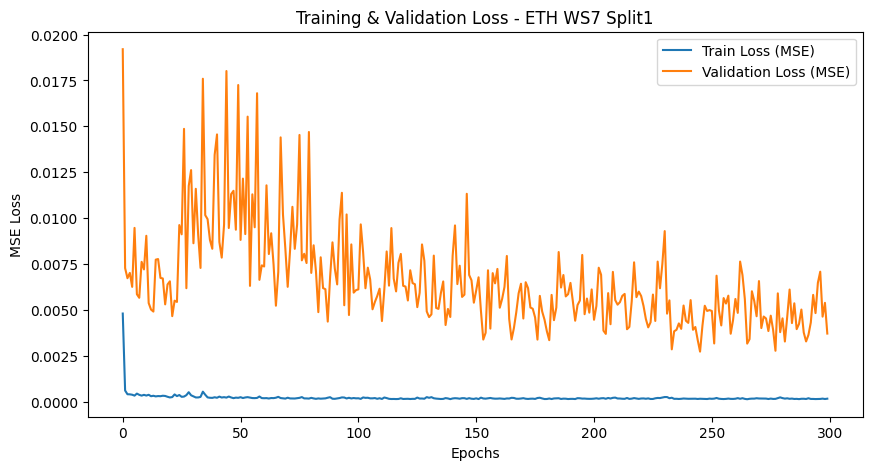

[ETH - WS7 - Split 1] Best Model saved
Avg Train Loss: 0.0002, Avg Validation Loss: 0.0066

=== Training ETH (WS7) on Split 2 ===


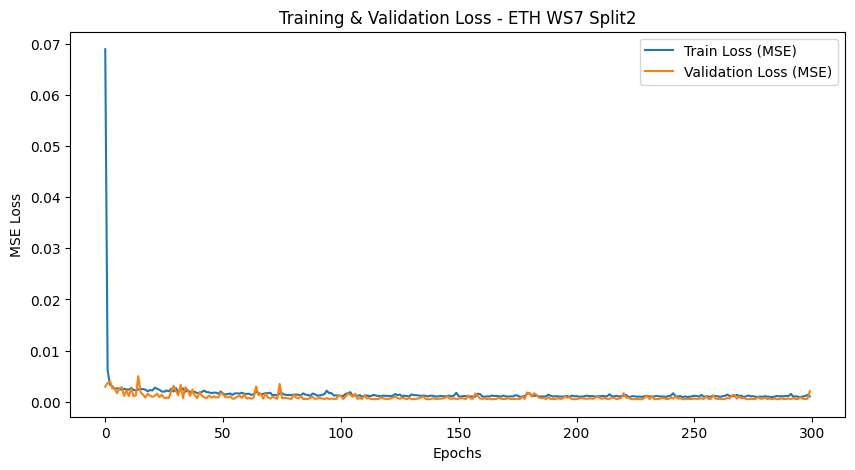

[ETH - WS7 - Split 2] Best Model saved
Avg Train Loss: 0.0016, Avg Validation Loss: 0.0009

=== Training ETH (WS7) on Split 3 ===


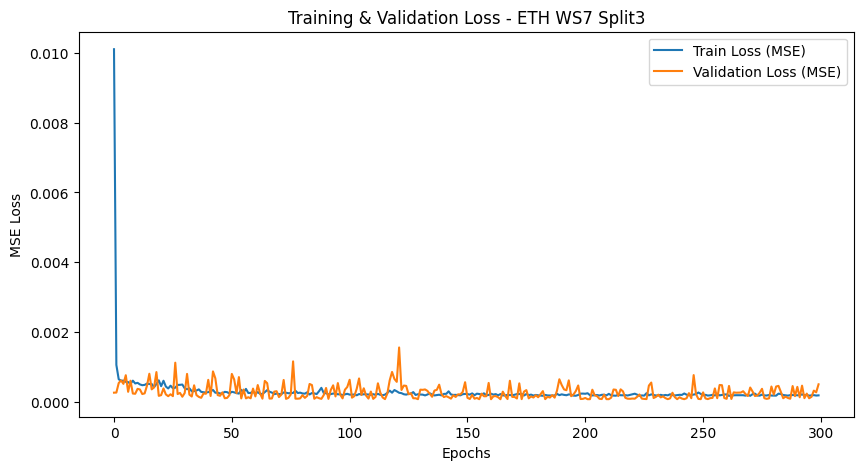

[ETH - WS7 - Split 3] Best Model saved
Avg Train Loss: 0.0003, Avg Validation Loss: 0.0003

=== Training ETH (WS7) on Split 4 ===


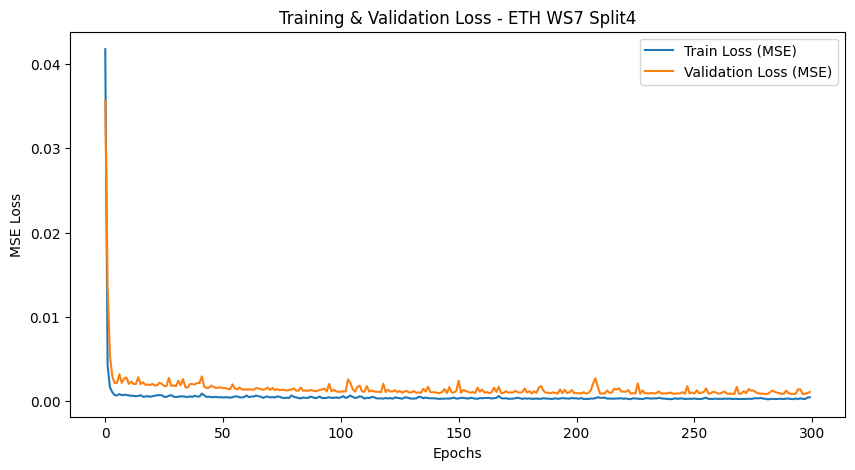

[ETH - WS7 - Split 4] Best Model saved
Avg Train Loss: 0.0005, Avg Validation Loss: 0.0015


In [103]:
perform_rwcv('eth', 7, best_params_eth_7, dataframes_eth, eth_scaler, save_dir = "/kaggle/working/bilstm")


Loading best model: /kaggle/working/bilstm/best_model_btc_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Confusion Matrix
[[39 44]
 [47 45]]
[Test Evaluation] BTC WS7 Split 2
MAPE: 2.6206%, DA: 48.0000%, RMSE: 2269.9983


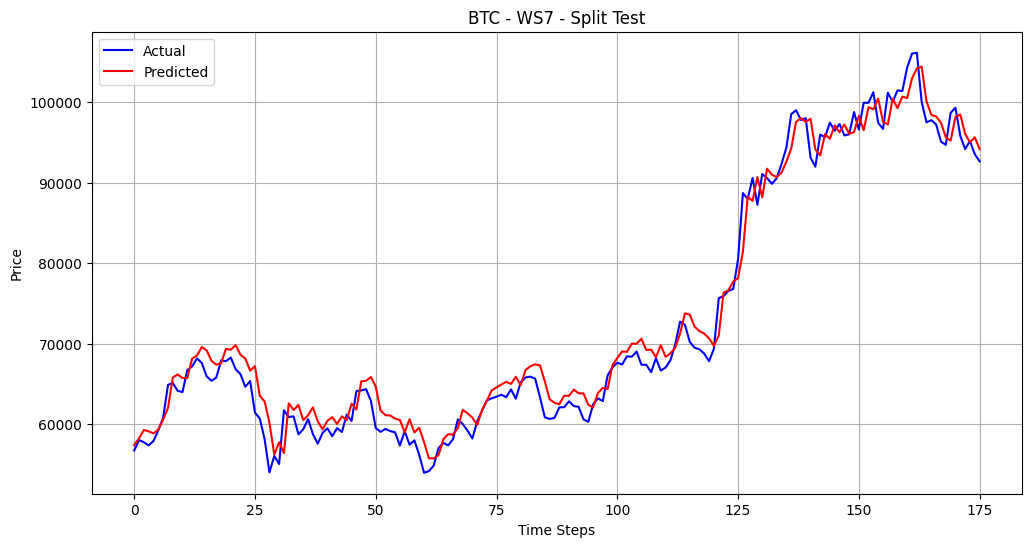

In [104]:
evaluate_test_model("btc", 7, split_idx=2, dataframes=dataframes_btc, scaler=btc_scaler, save_dir="/kaggle/working/bilstm")


Loading best model: /kaggle/working/bilstm/best_model_eth_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Confusion Matrix
[[37 46]
 [44 48]]
[Test Evaluation] ETH WS7 Split 2
MAPE: 5.8488%, DA: 48.5714%, RMSE: 187.9535


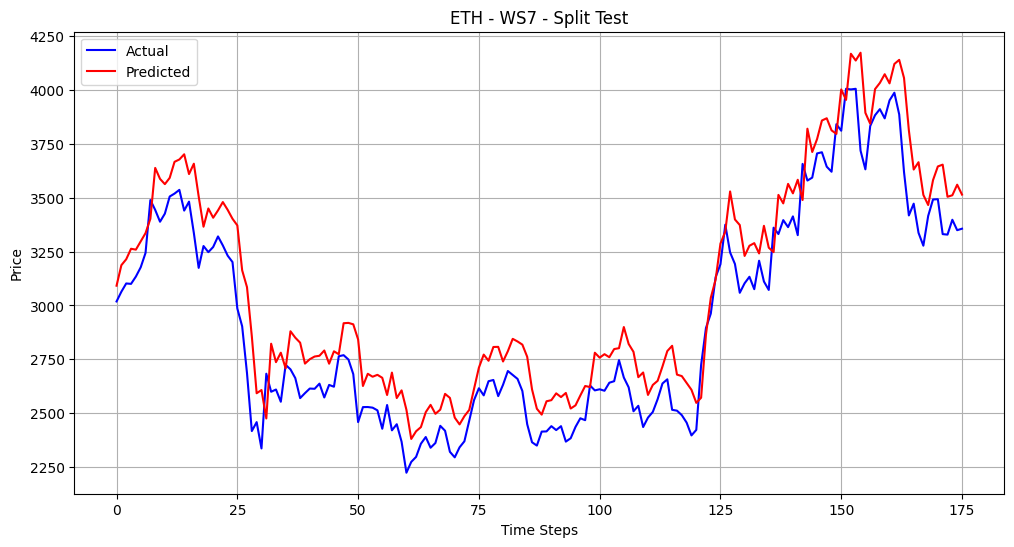

In [105]:
evaluate_test_model("eth", 7, split_idx=2, dataframes=dataframes_eth, scaler=eth_scaler, save_dir="/kaggle/working/bilstm")

## **CNN-LSTM**

In [106]:
save_dir = "/kaggle/working/cnn-lstm"
os.makedirs(save_dir, exist_ok=True)

In [107]:
# Fungsi untuk menambahkan ModelCheckpoint
def get_model_checkpoint(asset, window_size, split_idx):
    # Tentukan lokasi penyimpanan model terbaik
    model_filename = (f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras")
    model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', save_best_only=True)
    return model_checkpoint

In [108]:
# Fungsi untuk membangun CNN-LSTM model
def build_cnn_lstm_model(input_shape, filters, kernel_size, pool_size, learning_rate, dropout_rate, lstm_units1, lstm_units2, dense_units):
    model = Sequential()
    # CNN Layer
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))

    # LSTM Layers
    model.add(LSTM(lstm_units1, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units2))

    # Dense Layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))  # Output Layer

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [109]:
def train_and_validate_split(
    asset, window_size, train_data, val_data, best_params, split_idx, scaler, save_dir
):

    train_X, train_y = train_data
    val_X, val_y = val_data

    # Bangun model dengan hyperparameters terbaik
    model = build_cnn_lstm_model(
        input_shape=(train_X.shape[1], 1),
        filters=best_params['filters'],
        kernel_size=best_params['kernel_size'],
        pool_size=best_params['pool_size'],
        learning_rate=best_params['learning_rate'],
        dropout_rate=best_params['dropout_rate'],
        lstm_units1=best_params['lstm_units1'],
        lstm_units2=best_params['lstm_units2'],
        dense_units=best_params['dense_units']
    )

    # Checkpoint
    model_checkpoint = get_model_checkpoint(asset, window_size, split_idx)
    history = model.fit(
        train_X, train_y,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[model_checkpoint]
    )

    # Plot Loss (MSE) Training & Validation
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title(f'Training & Validation Loss - {asset.upper()} WS{window_size} Split{split_idx}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    # Hitung rata-rata loss selama pelatihan
    avg_train_loss = np.mean(history.history['loss'])
    avg_val_loss = np.mean(history.history['val_loss'])

    print(f"[{asset.upper()} - WS{window_size} - Split {split_idx}] Best Model saved")
    print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}")

    model.save(f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras")
    return model

In [110]:
def perform_rwcv(asset, window_size, best_params, dataframes, scaler, save_dir):

    window_size_str = f'ws{window_size}'

    for split_idx in range(1, 5):
        print(f"\n=== Training {asset.upper()} (WS{window_size}) on Split {split_idx} ===")

        # Ambil data train & val
        train_X = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_train_X')
        train_y = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_train_y')
        val_X = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_val_X')
        val_y = dataframes.get(f'{asset.lower()}_split{split_idx}_{window_size_str}_val_y')

        # Latih & Validasi
        train_and_validate_split(
            asset, window_size,
            (train_X, train_y), (val_X, val_y),
            best_params, split_idx, scaler,
            save_dir
        )

In [111]:
def evaluate_test_model(asset, window_size, split_idx, dataframes, scaler, save_dir):

    window_size_str = f'ws{window_size}'

    # Path model terbaik (sesuai naming checkpoint)
    model_filename = f"{save_dir}/best_model_{asset}_{window_size}_split{split_idx}.keras"

    print(f"\nLoading best model: {model_filename}")
    model = load_model(model_filename)

    # Ambil data test
    test_X = dataframes.get(f'{asset.lower()}_{window_size_str}_test_X')
    test_y = dataframes.get(f'{asset.lower()}_{window_size_str}_test_y')

    # Prediksi
    predictions = model.predict(test_X)

    # Inverse transform
    test_y_original = scaler.inverse_transform(test_y.values.reshape(-1, 1)).flatten()
    predictions_original = scaler.inverse_transform(predictions).flatten()

    # Hitung metrik
    mape = evaluate_mape(test_y_original, predictions_original)
    da = evaluate_direction_accuracy(test_y_original, predictions_original)
    rmse = evaluate_rmse(test_y_original, predictions_original)

    print(f"[Test Evaluation] {asset.upper()} WS{window_size} Split {split_idx}")
    print(f"MAPE: {mape:.4f}%, DA: {da:.4f}%, RMSE: {rmse:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_y_original, label='Actual', color='blue')
    plt.plot(predictions_original, label='Predicted', color='red')
    plt.title(f"{asset.upper()} - WS{window_size} - Split Test")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

#### BTC

In [112]:
# Fungsi untuk mendefinisikan Objective untuk optimasi Optuna
def objective_btc_split(trial, split_idx, asset, window_size):
    filters = trial.suggest_categorical('filters', [32])
    kernel_size = trial.suggest_categorical('kernel_size', [3])
    pool_size = trial.suggest_categorical('pool_size', [1])
    lstm_units1 = trial.suggest_categorical('lstm_units1', [32, 64, 128])
    lstm_units2 = trial.suggest_categorical('lstm_units2', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [100, 200, 300])

    # Load dataset sesuai split
    train_X = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_train_X']
    train_y = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_train_y']
    val_X = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_val_X']
    val_y = dataframes_btc[f'{asset.lower()}_split{split_idx}_{window_size}_val_y']

    # Build model
    model = build_cnn_lstm_model(
        input_shape=(train_X.shape[1], 1),
        filters=filters,
        kernel_size=kernel_size,
        pool_size=pool_size,
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        lstm_units1=lstm_units1,
        lstm_units2=lstm_units2,
        dense_units=dense_units
    )

    # Training model
    history = model.fit(
        train_X, train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluation using validation data
    val_predictions = model.predict(val_X)
    val_mse = mean_squared_error(val_y, val_predictions)
    return val_mse

In [113]:
def optimize_split_2(asset, window_size):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    print(f"Optimizing {asset} {window_size} - Split 2")
    optimization_start_time = log_time_progress(f"Starting Optuna optimization for {asset} {window_size} - Split 2")
    study.optimize(lambda trial: objective_btc_split(trial, 2, asset, window_size), n_trials=50)
    best_params = study.best_params
    print(f"Best params for {asset} {window_size} - Split 2:", best_params)
    return best_params

In [114]:
# Optimasi untuk split 2
best_params_btc_7 = optimize_split_2('BTC', 'ws7')

[I 2025-03-05 15:16:33,857] A new study created in memory with name: no-name-5a5bf8a4-a9dc-4be4-8cdf-c9a68cc3ee87


Optimizing BTC ws7 - Split 2
Starting Optuna optimization for BTC ws7 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:16:37,867] Trial 0 finished with value: 0.0973914043805305 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.0973914043805305.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:16:42,067] Trial 1 finished with value: 0.002149070696909973 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.002149070696909973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:16:45,345] Trial 2 finished with value: 0.030644234522974996 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.002149070696909973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-03-05 15:16:48,857] Trial 3 finished with value: 0.612875391607786 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 1 with value: 0.002149070696909973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:16:52,114] Trial 4 finished with value: 0.03428730434210129 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.002149070696909973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:16:55,398] Trial 5 finished with value: 14.942377723789651 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 1 with value: 0.002149070696909973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:16:58,955] Trial 6 finished with value: 0.0020638848607245916 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.0020638848607245916.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:17:02,525] Trial 7 finished with value: 5.349663472336027 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 6 with value: 0.0020638848607245916.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:17:06,030] Trial 8 finished with value: 0.01699612375663406 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 6 with value: 0.0020638848607245916.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:17:09,294] Trial 9 finished with value: 0.001179038112163144 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:17:12,589] Trial 10 finished with value: 0.0019182698378859395 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:17:15,851] Trial 11 finished with value: 0.016897038540764905 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2025-03-05 15:17:19,114] Trial 12 finished with value: 0.027367091628732187 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:17:22,432] Trial 13 finished with value: 0.0027930569546484145 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:17:25,647] Trial 14 finished with value: 0.0037227939907880686 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:17:28,894] Trial 15 finished with value: 0.030820961948943897 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-03-05 15:17:32,906] Trial 16 finished with value: 0.008909871836814449 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:17:36,126] Trial 17 finished with value: 0.008240428814478028 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:17:39,414] Trial 18 finished with value: 0.003451767669106742 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:17:43,425] Trial 19 finished with value: 0.02120516045675275 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:17:46,744] Trial 20 finished with value: 0.0026475083166112466 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:17:50,296] Trial 21 finished with value: 0.008575712973199886 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-03-05 15:17:53,830] Trial 22 finished with value: 0.04433566349514013 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:17:57,361] Trial 23 finished with value: 0.0015941043262074578 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:18:00,887] Trial 24 finished with value: 0.025434882197947678 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-03-05 15:18:04,441] Trial 25 finished with value: 0.014468377775098585 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:18:07,702] Trial 26 finished with value: 0.009259421800767716 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:18:10,999] Trial 27 finished with value: 0.014182106932077086 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2025-03-05 15:18:15,037] Trial 28 finished with value: 0.024639830429851045 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-03-05 15:18:18,636] Trial 29 finished with value: 0.004020267684724219 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2025-03-05 15:18:22,661] Trial 30 finished with value: 0.07045444475831562 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:18:26,191] Trial 31 finished with value: 0.0014211733462495648 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-03-05 15:18:29,708] Trial 32 finished with value: 0.007945628374247102 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:18:33,258] Trial 33 finished with value: 0.008472641292164872 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


[I 2025-03-05 15:18:54,125] Trial 34 finished with value: 0.00550286908761558 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


[I 2025-03-05 15:18:58,152] Trial 35 finished with value: 0.02282544427926882 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[I 2025-03-05 15:19:01,762] Trial 36 finished with value: 0.023647022118107954 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2025-03-05 15:19:05,617] Trial 37 finished with value: 0.04255624162381134 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2025-03-05 15:19:10,039] Trial 38 finished with value: 0.05011585944667142 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2025-03-05 15:19:13,592] Trial 39 finished with value: 0.03163176726147497 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2025-03-05 15:19:17,353] Trial 40 finished with value: 0.01742936819252499 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:19:21,207] Trial 41 finished with value: 0.03096884519946474 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


[I 2025-03-05 15:19:24,905] Trial 42 finished with value: 0.011893837420814292 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:19:28,634] Trial 43 finished with value: 0.023238520187679364 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2025-03-05 15:19:32,392] Trial 44 finished with value: 0.05166438353543332 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:19:35,787] Trial 45 finished with value: 0.03176098001855177 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


[I 2025-03-05 15:19:39,216] Trial 46 finished with value: 0.05066822618822921 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-03-05 15:19:42,965] Trial 47 finished with value: 0.0021342465962246085 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 300}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:19:46,366] Trial 48 finished with value: 0.0033502715384850852 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100}. Best is trial 9 with value: 0.001179038112163144.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


[I 2025-03-05 15:19:50,218] Trial 49 finished with value: 0.03628876858000383 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200}. Best is trial 9 with value: 0.001179038112163144.


Best params for BTC ws7 - Split 2: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}


In [134]:
best_params_btc_7 = {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 
                     'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 
                     'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}

In [116]:
# Optimasi untuk split 2
best_params_btc_14 = optimize_split_2('BTC', 'ws14')

[I 2025-03-05 15:21:48,796] A new study created in memory with name: no-name-d4f50884-c3f1-48d1-a359-bc518bb3fec7


Optimizing BTC ws14 - Split 2
Starting Optuna optimization for BTC ws14 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:21:53,203] Trial 0 finished with value: 0.02989473978292794 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.02989473978292794.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2025-03-05 15:21:57,699] Trial 1 finished with value: 0.047320742812094155 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 0 with value: 0.02989473978292794.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2025-03-05 15:22:01,195] Trial 2 finished with value: 0.0201893298587561 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.0201893298587561.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2025-03-05 15:22:04,929] Trial 3 finished with value: 0.8011136232119674 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.0201893298587561.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2025-03-05 15:22:08,405] Trial 4 finished with value: 0.000862910784819087 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:22:11,940] Trial 5 finished with value: 5.985283338621628 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-03-05 15:22:15,741] Trial 6 finished with value: 0.004070767590851207 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:22:19,484] Trial 7 finished with value: 0.05126405677789911 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2025-03-05 15:22:23,303] Trial 8 finished with value: 0.016283578537104517 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:22:26,687] Trial 9 finished with value: 0.00306810419651757 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:22:30,184] Trial 10 finished with value: 0.0157787018447526 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-03-05 15:22:33,579] Trial 11 finished with value: 0.02847405419397176 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:22:36,933] Trial 12 finished with value: 0.035245084276355754 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2025-03-05 15:22:40,266] Trial 13 finished with value: 0.012170442911999873 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-03-05 15:22:43,624] Trial 14 finished with value: 0.005854986550954859 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:22:46,947] Trial 15 finished with value: 0.01956418528930089 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:22:51,181] Trial 16 finished with value: 0.003886088552862923 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-03-05 15:22:54,557] Trial 17 finished with value: 0.007066436313077237 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


[I 2025-03-05 15:22:57,975] Trial 18 finished with value: 0.0016317725651022119 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-03-05 15:23:02,431] Trial 19 finished with value: 0.0012231526160602032 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:23:06,665] Trial 20 finished with value: 0.004113331146291244 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:23:11,005] Trial 21 finished with value: 0.0012073072294779487 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 4 with value: 0.000862910784819087.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:23:15,179] Trial 22 finished with value: 0.000835525258709217 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2025-03-05 15:23:19,410] Trial 23 finished with value: 0.0008726450038106351 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:23:23,644] Trial 24 finished with value: 0.0012061474681906187 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:23:27,829] Trial 25 finished with value: 0.0010879914310221194 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-03-05 15:23:32,275] Trial 26 finished with value: 0.000892789740586635 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


[I 2025-03-05 15:23:36,407] Trial 27 finished with value: 0.0013702312824440549 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2025-03-05 15:23:40,560] Trial 28 finished with value: 0.001169680651169205 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-03-05 15:23:44,673] Trial 29 finished with value: 0.08972949991955982 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:23:48,829] Trial 30 finished with value: 0.0021911457620356197 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:23:53,046] Trial 31 finished with value: 0.0010129977115777141 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:23:57,243] Trial 32 finished with value: 0.0008589498454576248 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-03-05 15:24:01,368] Trial 33 finished with value: 0.0009137886759414294 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-03-05 15:24:05,554] Trial 34 finished with value: 0.0014573651656956987 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:24:09,697] Trial 35 finished with value: 0.007829047634144513 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-03-05 15:24:13,303] Trial 36 finished with value: 0.2910454233032428 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:24:17,393] Trial 37 finished with value: 0.0010384493306382556 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-03-05 15:24:21,091] Trial 38 finished with value: 0.19218193028340808 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:24:25,288] Trial 39 finished with value: 0.0033991250045638543 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:24:28,870] Trial 40 finished with value: 0.009212317997821316 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:24:33,024] Trial 41 finished with value: 0.0020378859666023426 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:24:37,219] Trial 42 finished with value: 0.001172734860322077 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:24:41,418] Trial 43 finished with value: 0.002140740051840455 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-03-05 15:24:45,526] Trial 44 finished with value: 0.0018611147280151107 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2025-03-05 15:24:48,879] Trial 45 finished with value: 0.03018777494201015 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:24:53,073] Trial 46 finished with value: 0.6034564081130508 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 200}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:24:56,410] Trial 47 finished with value: 0.030305877232984706 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-03-05 15:25:00,050] Trial 48 finished with value: 0.0012562106250041157 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200}. Best is trial 22 with value: 0.000835525258709217.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:25:04,171] Trial 49 finished with value: 0.014671127508579216 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 22 with value: 0.000835525258709217.


Best params for BTC ws14 - Split 2: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}


In [128]:
best_params_btc_14 = {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 
                      'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 
                      'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}


=== Training BTC (WS7) on Split 1 ===


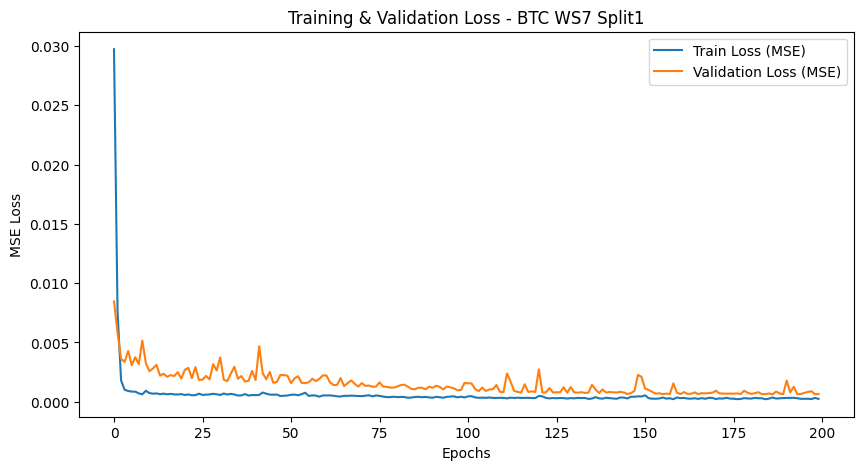

[BTC - WS7 - Split 1] Best Model saved
Avg Train Loss: 0.0006, Avg Validation Loss: 0.0015

=== Training BTC (WS7) on Split 2 ===


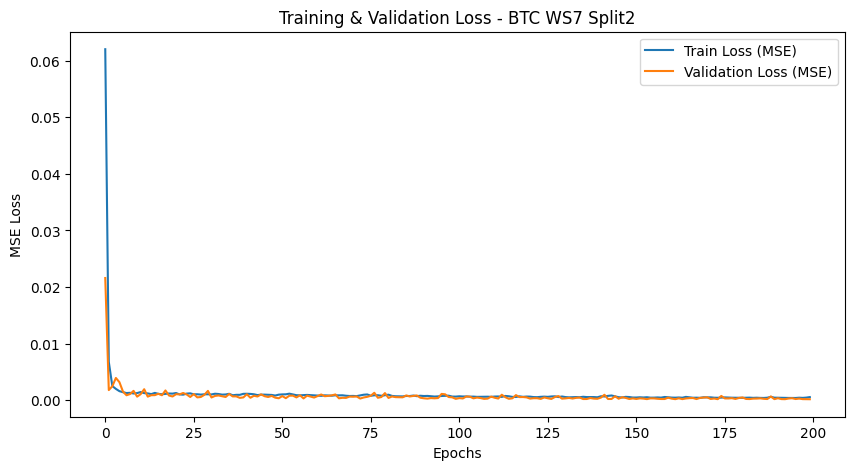

[BTC - WS7 - Split 2] Best Model saved
Avg Train Loss: 0.0011, Avg Validation Loss: 0.0007

=== Training BTC (WS7) on Split 3 ===


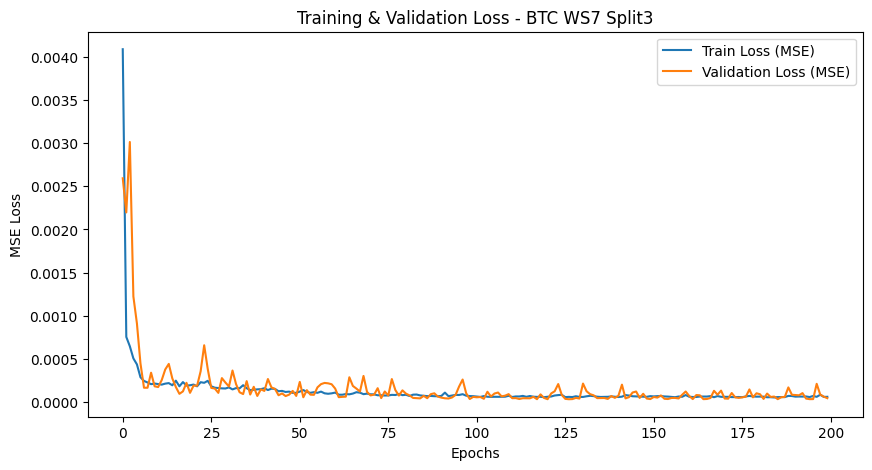

[BTC - WS7 - Split 3] Best Model saved
Avg Train Loss: 0.0001, Avg Validation Loss: 0.0002

=== Training BTC (WS7) on Split 4 ===


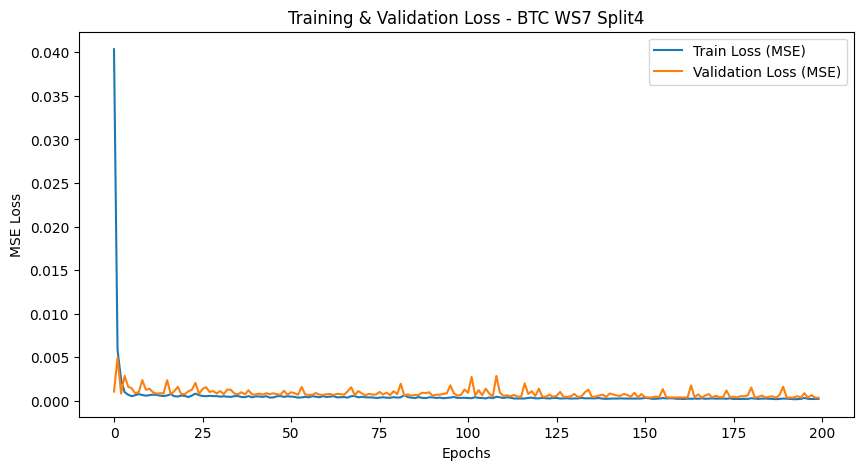

[BTC - WS7 - Split 4] Best Model saved
Avg Train Loss: 0.0006, Avg Validation Loss: 0.0009


In [135]:
perform_rwcv('btc', 7, best_params_btc_7, dataframes_btc, btc_scaler, save_dir = "/kaggle/working/cnn-lstm")

#### ETH

In [119]:
# Fungsi untuk mendefinisikan Objective untuk optimasi Optuna
def objective_eth_split(trial, split_idx, asset, window_size):
    filters = trial.suggest_categorical('filters', [32])
    kernel_size = trial.suggest_categorical('kernel_size', [3])
    pool_size = trial.suggest_categorical('pool_size', [1])
    lstm_units1 = trial.suggest_categorical('lstm_units1', [32, 64, 128])
    lstm_units2 = trial.suggest_categorical('lstm_units2', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [100, 200, 300])

    # Load dataset sesuai split
    train_X = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_train_X']
    train_y = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_train_y']
    val_X = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_val_X']
    val_y = dataframes_eth[f'{asset.lower()}_split{split_idx}_{window_size}_val_y']

    # Build model
    model = build_cnn_lstm_model(
        input_shape=(train_X.shape[1], 1),
        filters=filters,
        kernel_size=kernel_size,
        pool_size=pool_size,
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        lstm_units1=lstm_units1,
        lstm_units2=lstm_units2,
        dense_units=dense_units
    )

    # Training model
    history = model.fit(
        train_X, train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluation using validation data
    val_predictions = model.predict(val_X)
    val_mse = mean_squared_error(val_y, val_predictions)
    return val_mse

In [120]:
def optimize_split_2(asset, window_size):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    print(f"Optimizing {asset} {window_size} - Split 2")
    optimization_start_time = log_time_progress(f"Starting Optuna optimization for {asset} {window_size} - Split 2")
    study.optimize(lambda trial: objective_eth_split(trial, 2, asset, window_size), n_trials=50)
    best_params = study.best_params
    print(f"Best params for {asset} {window_size} - Split 2:", best_params)
    return best_params

In [121]:
# Optimasi untuk split 2
best_params_eth_7 = optimize_split_2('ETH', 'ws7')

[I 2025-03-05 15:32:44,159] A new study created in memory with name: no-name-8d2f7169-50b2-4f12-bf16-b1d38663d8de


Optimizing ETH ws7 - Split 2
Starting Optuna optimization for ETH ws7 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:32:48,140] Trial 0 finished with value: 0.06867828812864565 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.06867828812864565.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:32:52,150] Trial 1 finished with value: 0.01372084357611905 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.01372084357611905.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:32:55,387] Trial 2 finished with value: 0.11647963128781189 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.01372084357611905.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:32:58,917] Trial 3 finished with value: 2.723596333402572 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 1 with value: 0.01372084357611905.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:33:02,284] Trial 4 finished with value: 0.12770595291101602 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 1 with value: 0.01372084357611905.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:33:05,506] Trial 5 finished with value: 22.867231667752147 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 1 with value: 0.01372084357611905.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:33:08,994] Trial 6 finished with value: 0.0340936882298378 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 1 with value: 0.01372084357611905.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:33:12,522] Trial 7 finished with value: 0.11369105303950434 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 1 with value: 0.01372084357611905.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:33:16,027] Trial 8 finished with value: 0.011504635659749496 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.011504635659749496.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:33:19,266] Trial 9 finished with value: 0.06172240191240205 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 8 with value: 0.011504635659749496.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-03-05 15:33:22,815] Trial 10 finished with value: 0.021518122565437423 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 8 with value: 0.011504635659749496.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:33:26,781] Trial 11 finished with value: 0.023260646407328774 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 8 with value: 0.011504635659749496.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


[I 2025-03-05 15:33:30,885] Trial 12 finished with value: 0.009466189352065668 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 12 with value: 0.009466189352065668.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2025-03-05 15:33:34,900] Trial 13 finished with value: 0.008676225182453114 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 13 with value: 0.008676225182453114.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:33:38,889] Trial 14 finished with value: 0.010230404747751288 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 13 with value: 0.008676225182453114.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:33:42,958] Trial 15 finished with value: 0.05235734500134433 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 13 with value: 0.008676225182453114.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:33:46,972] Trial 16 finished with value: 0.005266610790510917 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.005266610790510917.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-03-05 15:33:50,994] Trial 17 finished with value: 0.04633497023598219 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.005266610790510917.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2025-03-05 15:33:54,914] Trial 18 finished with value: 0.0679480461280095 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.005266610790510917.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:33:58,895] Trial 19 finished with value: 0.030346019101110393 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 16 with value: 0.005266610790510917.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:34:03,071] Trial 20 finished with value: 0.004032088244081763 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 20 with value: 0.004032088244081763.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:34:07,076] Trial 21 finished with value: 0.04369616652805105 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 20 with value: 0.004032088244081763.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:34:11,184] Trial 22 finished with value: 0.008368109776916446 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 20 with value: 0.004032088244081763.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2025-03-05 15:34:15,214] Trial 23 finished with value: 0.022362352515895263 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 20 with value: 0.004032088244081763.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:34:19,288] Trial 24 finished with value: 0.0034448670000505575 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2025-03-05 15:34:23,307] Trial 25 finished with value: 0.018174171308370672 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:34:27,281] Trial 26 finished with value: 0.05912613549836079 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:34:31,342] Trial 27 finished with value: 0.045530366529883994 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:34:34,679] Trial 28 finished with value: 0.2006516231144181 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:34:38,726] Trial 29 finished with value: 0.009363489561757388 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:34:42,804] Trial 30 finished with value: 0.03870422920118067 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:34:46,873] Trial 31 finished with value: 0.03291474592757268 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:34:51,000] Trial 32 finished with value: 0.0119655370748882 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:34:55,032] Trial 33 finished with value: 0.009484489585678013 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-03-05 15:34:59,035] Trial 34 finished with value: 0.01944118843798525 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-03-05 15:35:03,076] Trial 35 finished with value: 0.03510889713482349 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2025-03-05 15:35:06,464] Trial 36 finished with value: 0.18497922253076937 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2025-03-05 15:35:10,514] Trial 37 finished with value: 0.042774925046533595 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2025-03-05 15:35:14,139] Trial 38 finished with value: 0.07789576830356425 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:35:17,482] Trial 39 finished with value: 0.12722102048860529 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:35:21,589] Trial 40 finished with value: 0.011786528153665474 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-03-05 15:35:25,647] Trial 41 finished with value: 0.03825523196750917 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:35:29,784] Trial 42 finished with value: 0.03992373457565909 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:35:33,352] Trial 43 finished with value: 0.019146723283046292 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:35:37,479] Trial 44 finished with value: 0.07009080085329897 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-03-05 15:35:41,627] Trial 45 finished with value: 0.019156294053094373 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:35:45,732] Trial 46 finished with value: 0.09001785323641585 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:35:49,315] Trial 47 finished with value: 0.18273597247212184 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:35:52,620] Trial 48 finished with value: 0.02084167952595921 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 24 with value: 0.0034448670000505575.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-03-05 15:35:56,669] Trial 49 finished with value: 0.02528627695162 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 24 with value: 0.0034448670000505575.


Best params for ETH ws7 - Split 2: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}


In [122]:
best_params_eth_7 = {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 
                     'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 
                     'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 300}

In [123]:
# Optimasi untuk split 2
best_params_eth_14 = optimize_split_2('ETH', 'ws14')

[I 2025-03-05 15:38:08,041] A new study created in memory with name: no-name-ce6a8f39-c98b-4863-a171-948c987ed8de


Optimizing ETH ws14 - Split 2
Starting Optuna optimization for ETH ws14 - Split 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-03-05 15:38:12,193] Trial 0 finished with value: 0.013796803233250558 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 300}. Best is trial 0 with value: 0.013796803233250558.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:38:16,512] Trial 1 finished with value: 0.01181386724195331 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 200}. Best is trial 1 with value: 0.01181386724195331.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:38:19,816] Trial 2 finished with value: 0.003933279432961779 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.003933279432961779.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:38:23,446] Trial 3 finished with value: 0.561292978092495 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 0.003933279432961779.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:38:26,723] Trial 4 finished with value: 0.07468791322614557 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 2 with value: 0.003933279432961779.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:38:30,055] Trial 5 finished with value: 2.4745212650364317 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 300}. Best is trial 2 with value: 0.003933279432961779.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:38:33,706] Trial 6 finished with value: 0.0035756829684598446 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:38:37,304] Trial 7 finished with value: 0.011085250637503827 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:38:40,980] Trial 8 finished with value: 0.07650552089406272 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-03-05 15:38:44,251] Trial 9 finished with value: 0.005628575962224733 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:38:47,979] Trial 10 finished with value: 0.029515977067685793 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:38:51,349] Trial 11 finished with value: 0.03148401439898667 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2025-03-05 15:38:54,979] Trial 12 finished with value: 0.0082030707432933 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-03-05 15:38:58,344] Trial 13 finished with value: 0.010244793253561658 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-03-05 15:39:02,538] Trial 14 finished with value: 0.007520045228600221 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:39:06,157] Trial 15 finished with value: 0.07203483018647326 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


[I 2025-03-05 15:39:29,624] Trial 16 finished with value: 0.19711490943847787 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 300}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


[I 2025-03-05 15:39:33,415] Trial 17 finished with value: 0.04673261455434581 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2025-03-05 15:39:37,407] Trial 18 finished with value: 0.006867076255195713 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 128, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 300}. Best is trial 6 with value: 0.0035756829684598446.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[I 2025-03-05 15:39:41,961] Trial 19 finished with value: 0.0030814843367277635 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 19 with value: 0.0030814843367277635.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


[I 2025-03-05 15:39:46,531] Trial 20 finished with value: 0.022434811951909942 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100}. Best is trial 19 with value: 0.0030814843367277635.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-03-05 15:39:51,224] Trial 21 finished with value: 0.0038100868215099463 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 19 with value: 0.0030814843367277635.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-03-05 15:39:55,662] Trial 22 finished with value: 0.0032826876424258155 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 19 with value: 0.0030814843367277635.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2025-03-05 15:40:00,076] Trial 23 finished with value: 0.004284635582737921 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 19 with value: 0.0030814843367277635.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2025-03-05 15:40:04,497] Trial 24 finished with value: 0.004529944066637307 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 19 with value: 0.0030814843367277635.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2025-03-05 15:40:08,962] Trial 25 finished with value: 0.10473462002315777 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 19 with value: 0.0030814843367277635.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[I 2025-03-05 15:40:13,455] Trial 26 finished with value: 0.0043578231023058064 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 19 with value: 0.0030814843367277635.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


[I 2025-03-05 15:40:17,846] Trial 27 finished with value: 0.002913695186133625 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.002913695186133625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-03-05 15:40:22,657] Trial 28 finished with value: 0.003180777159735601 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.002913695186133625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-03-05 15:40:27,130] Trial 29 finished with value: 0.12283994427430348 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 27 with value: 0.002913695186133625.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2025-03-05 15:40:31,677] Trial 30 finished with value: 0.0024382478712057245 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2025-03-05 15:40:36,110] Trial 31 finished with value: 0.004543593847873075 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2025-03-05 15:40:40,461] Trial 32 finished with value: 0.004619153863849702 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2025-03-05 15:40:44,855] Trial 33 finished with value: 0.003585919437750928 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-03-05 15:40:49,175] Trial 34 finished with value: 0.003994649539458318 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


[I 2025-03-05 15:40:53,673] Trial 35 finished with value: 0.004630320499384273 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2025-03-05 15:40:58,023] Trial 36 finished with value: 0.004141376323583157 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2025-03-05 15:41:02,433] Trial 37 finished with value: 0.013986893103203267 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2025-03-05 15:41:06,809] Trial 38 finished with value: 0.003768330323509233 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[I 2025-03-05 15:41:11,142] Trial 39 finished with value: 0.08692316468025052 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2025-03-05 15:41:15,415] Trial 40 finished with value: 0.0044778192429575855 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


[I 2025-03-05 15:41:19,679] Trial 41 finished with value: 0.005321224922976634 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2025-03-05 15:41:23,933] Trial 42 finished with value: 0.005373279920719864 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-03-05 15:41:28,244] Trial 43 finished with value: 0.007910404715466004 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:41:32,522] Trial 44 finished with value: 0.0041240773109610255 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:41:36,958] Trial 45 finished with value: 0.0038464281692193905 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-03-05 15:41:41,279] Trial 46 finished with value: 0.08473992238702437 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-03-05 15:41:45,477] Trial 47 finished with value: 0.18880372323033265 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:41:49,689] Trial 48 finished with value: 0.006719964616991402 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 64, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}. Best is trial 30 with value: 0.0024382478712057245.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-03-05 15:41:53,094] Trial 49 finished with value: 0.051656121122075065 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 300}. Best is trial 30 with value: 0.0024382478712057245.


Best params for ETH ws14 - Split 2: {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'lstm_units1': 32, 'lstm_units2': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


In [143]:
best_params_eth_14 = {'filters': 32, 'kernel_size': 3, 'pool_size': 1, 
                      'lstm_units1': 32, 'lstm_units2': 64, 'dense_units': 32, 
                      'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}


=== Training ETH (WS14) on Split 1 ===


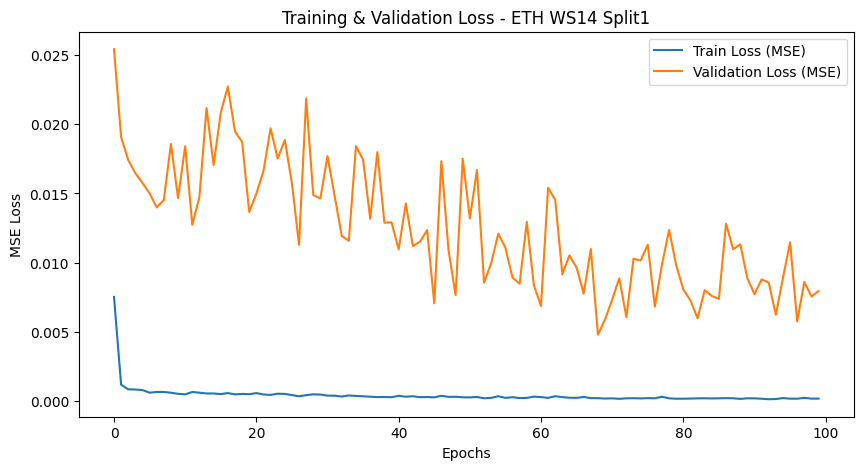

[ETH - WS14 - Split 1] Best Model saved
Avg Train Loss: 0.0004, Avg Validation Loss: 0.0126

=== Training ETH (WS14) on Split 2 ===


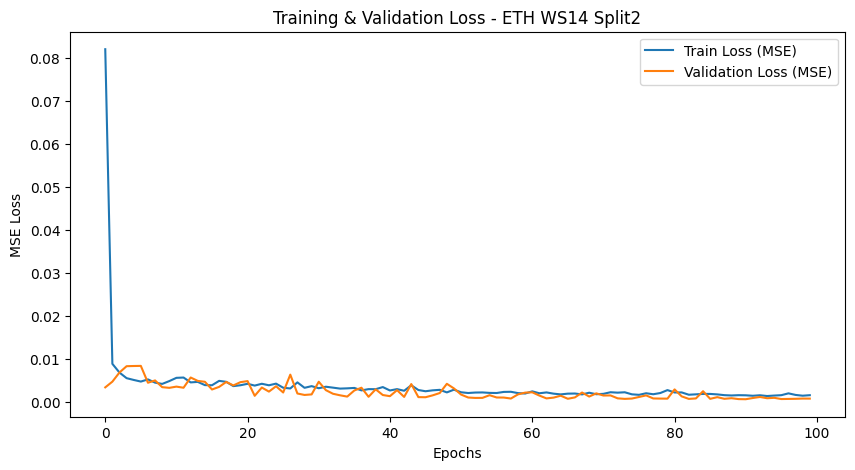

[ETH - WS14 - Split 2] Best Model saved
Avg Train Loss: 0.0037, Avg Validation Loss: 0.0023

=== Training ETH (WS14) on Split 3 ===


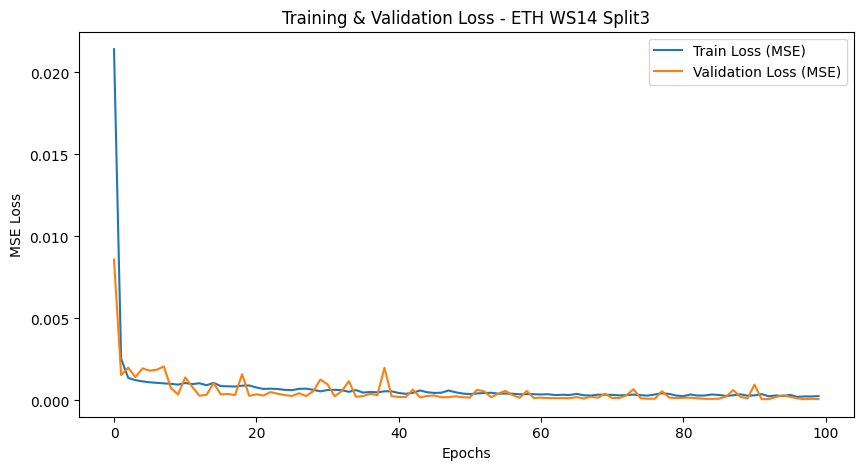

[ETH - WS14 - Split 3] Best Model saved
Avg Train Loss: 0.0008, Avg Validation Loss: 0.0006

=== Training ETH (WS14) on Split 4 ===


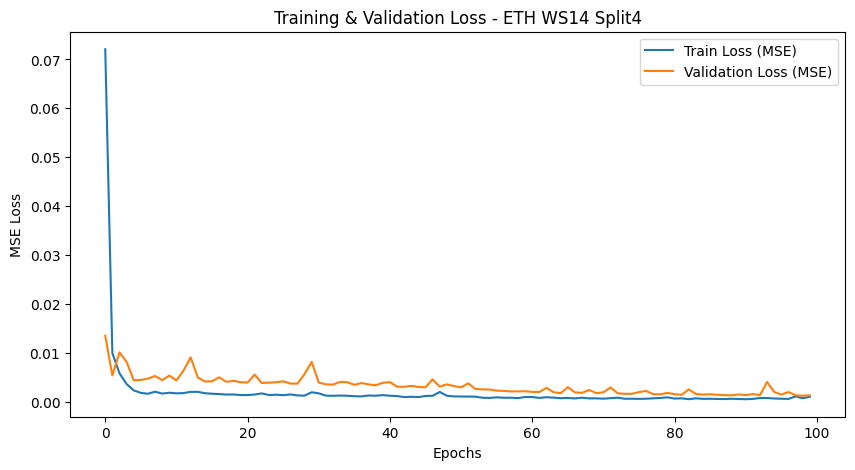

[ETH - WS14 - Split 4] Best Model saved
Avg Train Loss: 0.0019, Avg Validation Loss: 0.0033


In [144]:
perform_rwcv('eth', 14, best_params_eth_14, dataframes_eth, eth_scaler, save_dir = "/kaggle/working/cnn-lstm")


Loading best model: /kaggle/working/cnn-lstm/best_model_btc_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Confusion Matrix
[[38 45]
 [42 50]]
[Test Evaluation] BTC WS7 Split 2
MAPE: 4.4162%, DA: 50.2857%, RMSE: 4006.8244


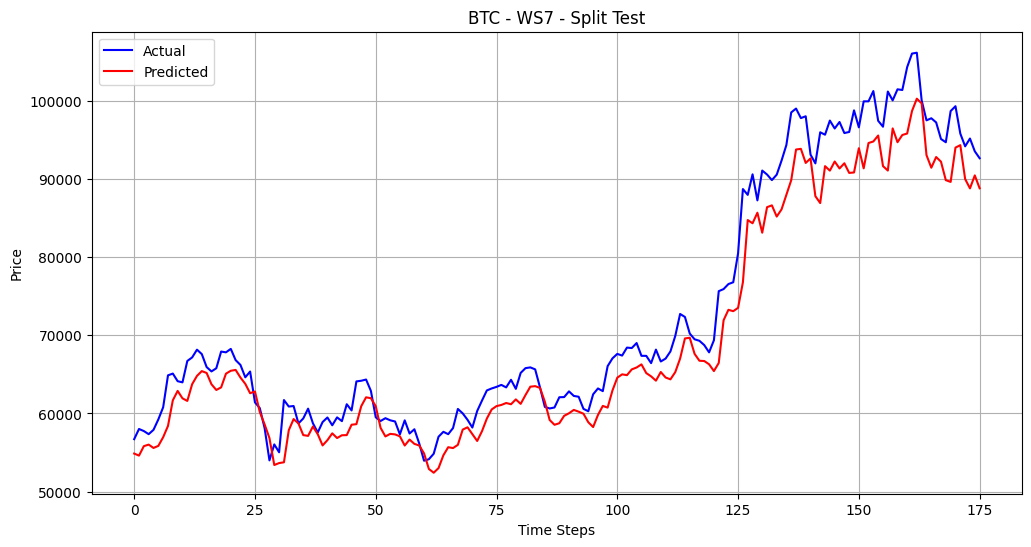

In [138]:
evaluate_test_model("btc", 7, split_idx=2, dataframes=dataframes_btc, scaler=btc_scaler, save_dir="/kaggle/working/cnn-lstm")


Loading best model: /kaggle/working/cnn-lstm/best_model_eth_14_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Confusion Matrix
[[33 49]
 [42 44]]
[Test Evaluation] ETH WS14 Split 2
MAPE: 3.0283%, DA: 45.8333%, RMSE: 118.6347


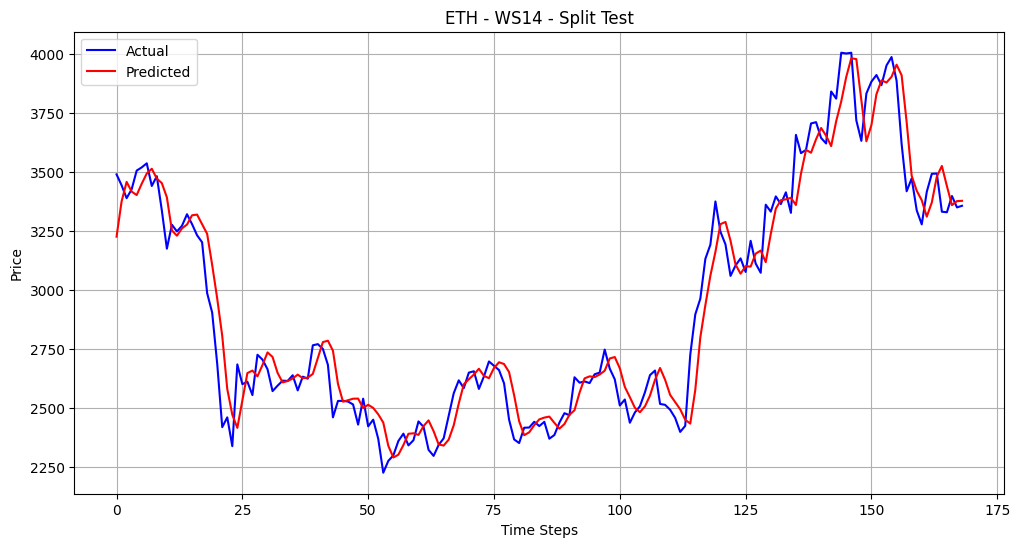

In [145]:
evaluate_test_model("eth", 14, split_idx=2, dataframes=dataframes_eth, scaler=eth_scaler, save_dir="/kaggle/working/cnn-lstm")

## **COMPARE**

In [146]:
def evaluate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_direction_accuracy(y_true, y_pred):
    # Hitung arah
    y_actual_direction = np.sign(np.diff(y_true))
    pred_direction = np.sign(np.diff(y_pred))
    # Filter hanya up/down (hapus 0 jika ada)
    mask = (y_actual_direction != 0) & (pred_direction != 0)
    y_actual_filtered = y_actual_direction[mask]
    pred_filtered = pred_direction[mask]
    da = np.mean(y_actual_filtered == pred_filtered) * 100
    return da

In [147]:
best_models_config = {
    "btc": {
        "LSTM":       {"window_size": 7, "split_idx": 2},
        "BiLSTM":     {"window_size": 7, "split_idx": 2},
        "CNN-LSTM":   {"window_size": 7, "split_idx": 2},
        "CNN-BiLSTM": {"window_size": 7,  "split_idx": 2}
    },
    "eth": {
        "LSTM":       {"window_size": 14, "split_idx": 2},
        "BiLSTM":     {"window_size": 7,  "split_idx": 2},
        "CNN-LSTM":   {"window_size": 14, "split_idx": 2},
        "CNN-BiLSTM": {"window_size": 14,  "split_idx": 2}
    }
}

In [148]:
model_folder_map = {
    "LSTM": "/kaggle/working/lstm",
    "BiLSTM": "/kaggle/working/bilstm",
    "CNN-LSTM": "/kaggle/working/cnn-lstm",
    "CNN-BiLSTM": "/kaggle/working/cnn-bilstm"
}

In [149]:
def compare_four_models_for_crypto(crypto, dataframes, scaler, best_models_config, model_folder_map):

    # Dictionary untuk menyimpan hasil prediksi dan metrik
    predictions_dict = {}
    
    # Loop setiap model (LSTM, BiLSTM, CNN-LSTM, CNN-BiLSTM)
    for model_name in ["LSTM", "BiLSTM", "CNN-LSTM", "CNN-BiLSTM"]:
        config = best_models_config[crypto][model_name]
        ws = config["window_size"]
        split_idx = config["split_idx"]
        
        # Tentukan folder tempat model disimpan berdasarkan model_name
        model_folder = model_folder_map[model_name]
        
        # Path model
        model_path = f"{model_folder}/best_model_{crypto}_{ws}_split{split_idx}.keras"
        print(f"Loading {model_name} model for {crypto.upper()} (WS={ws}, Split={split_idx}) -> {model_path}")
        
        # Load model
        model = load_model(model_path)
        
        # Ambil data test
        test_X = dataframes.get(f"{crypto}_ws{ws}_test_X")
        test_y = dataframes.get(f"{crypto}_ws{ws}_test_y")
        
        # Prediksi
        test_predictions = model.predict(test_X)
        
        # Inverse transform
        test_y_original = scaler.inverse_transform(test_y.values.reshape(-1,1)).flatten()
        predictions_original = scaler.inverse_transform(test_predictions).flatten()
        
        # Hitung metrik
        mape = evaluate_mape(test_y_original, predictions_original)
        rmse = evaluate_rmse(test_y_original, predictions_original)
        da = evaluate_direction_accuracy(test_y_original, predictions_original)
        
        # Simpan ke dictionary
        predictions_dict[model_name] = {
            "pred": predictions_original,
            "MAPE": mape,
            "RMSE": rmse,
            "DA": da
        }
        
        print(f"{model_name} -> MAPE: {mape:.4f}%, RMSE: {rmse:.4f}, DA: {da:.4f}%")
    
    # Plot perbandingan
    plt.figure(figsize=(12,6))
    # Plot data aktual
    plt.plot(test_y_original, label="Actual", color="black", linewidth=2)
    
    # Plot prediksi dari masing-masing model
    for model_name, data in predictions_dict.items():
        plt.plot(data["pred"], label=model_name)
    
    plt.title(f"{crypto.upper()} - Comparison of 4 Models on Split Test")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

Loading LSTM model for BTC (WS=7, Split=2) -> /kaggle/working/lstm/best_model_btc_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
LSTM -> MAPE: 2.3439%, RMSE: 2368.9323, DA: 50.86%
Loading BiLSTM model for BTC (WS=7, Split=2) -> /kaggle/working/bilstm/best_model_btc_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
BiLSTM -> MAPE: 2.6206%, RMSE: 2269.9983, DA: 48.00%
Loading CNN-LSTM model for BTC (WS=7, Split=2) -> /kaggle/working/cnn-lstm/best_model_btc_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
CNN-LSTM -> MAPE: 4.4162%, RMSE: 4006.8244, DA: 50.29%
Loading CNN-BiLSTM model for BTC (WS=7, Split=2) -> /kaggle/working/cnn-bilstm/best_model_btc_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
CNN-BiLSTM -> MAPE: 2.3633%, RMSE: 2326.8282, DA: 53.71%


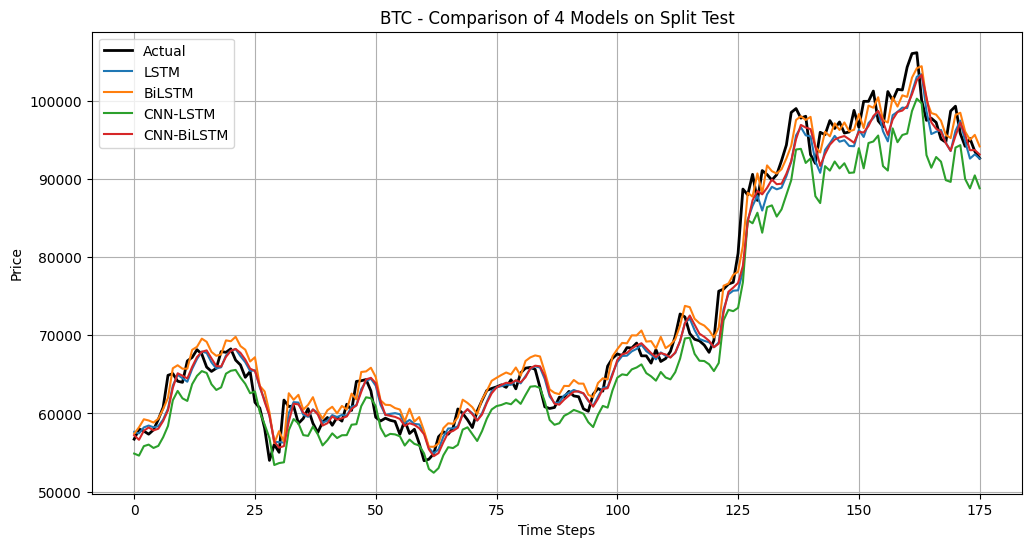

In [150]:
compare_four_models_for_crypto(
    crypto="btc",
    dataframes=dataframes_btc,
    scaler=btc_scaler,
    best_models_config=best_models_config,
    model_folder_map=model_folder_map
)

Loading LSTM model for ETH (WS=14, Split=2) -> /kaggle/working/lstm/best_model_eth_14_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
LSTM -> MAPE: 3.5121%, RMSE: 137.4961, DA: 47.02%
Loading BiLSTM model for ETH (WS=7, Split=2) -> /kaggle/working/bilstm/best_model_eth_7_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
BiLSTM -> MAPE: 5.8488%, RMSE: 187.9535, DA: 48.57%
Loading CNN-LSTM model for ETH (WS=14, Split=2) -> /kaggle/working/cnn-lstm/best_model_eth_14_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
CNN-LSTM -> MAPE: 3.0283%, RMSE: 118.6347, DA: 45.83%
Loading CNN-BiLSTM model for ETH (WS=14, Split=2) -> /kaggle/working/cnn-bilstm/best_model_eth_14_split2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
CNN-BiLSTM -> MAPE: 2.9424%, RMSE: 115.3399, DA: 50.60%


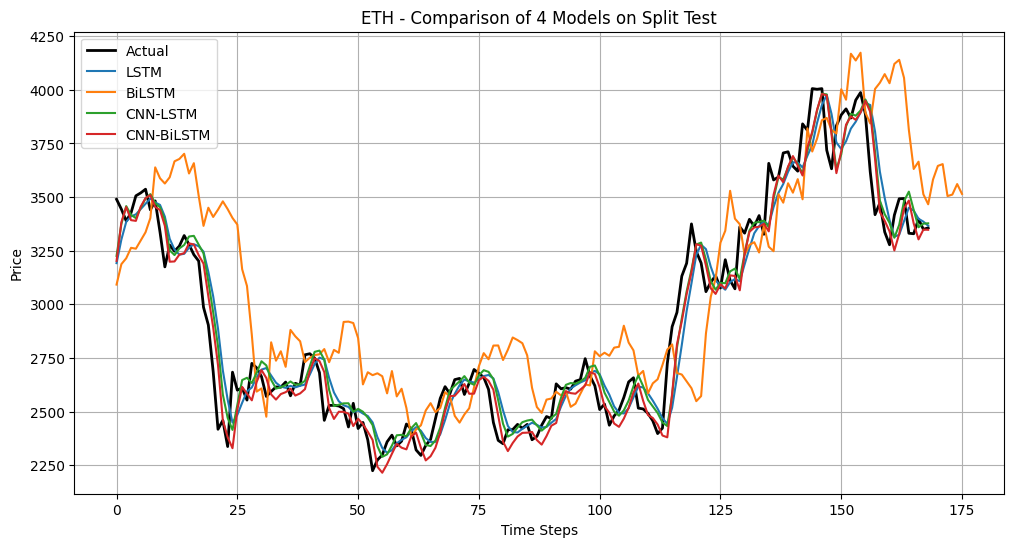

In [151]:
compare_four_models_for_crypto(
    crypto="eth",
    dataframes=dataframes_eth,
    scaler=eth_scaler,
    best_models_config=best_models_config,
    model_folder_map=model_folder_map
)

## **FORECASTING**